# Introduction to Problem Context and Problem Statement

Problem Context

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

- Problem Statement/Goal
    - It is your job to predict as accurately as possible if a passenger survived the sinking of the Titanic or not. For each in the test set, you must predict a 0 or 1 value for the variable.

- Metric (to be determined after EDA to determine degree of imbalance of classes within the datasets)
    - Your score is the percentage of passengers you correctly predict. This is known as accuracy.

- Submission File Format
    - You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

- `PassengerId` (sorted in any order)
- `Survived` (contains your binary predictions: 1 for survived, 0 for deceased)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include `gender_submission.csv`, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Schema

|Variable|	Definition|	Key| Data Type |
|------|------|------|----|
|`PassengerId`| Id No. of Passenger|1-891 for train.csv, 892-1309 for test.csv | `int`| 
|`Survived`|	Survival|	0 = No, 1 = Yes| `int` |
|`Pclass`|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd| `int` |
| `Name`| Name of passenger, including title|Braund, Mr. Owen Harris | `str`|
|`Sex`|	Sex| male, female| `str`	|
|`Age`|	Age in years| e.g. 40.5, 36|	`float`|
|`Sib Sp`|	# of siblings / spouses aboard the Titanic| e.g. 0 | `int` |
|`Parch`|	# of parents / children aboard the Titanic| e.g. 1 | `int`|	
|`Ticket`|	Ticket number| e.g. A/5. 2151 | `str` |	
|`Fare`|	Passenger fare| e.g. 26.55 | `float` |	
|`Cabin`|	Cabin number| e.g. C23 C25 C27|	`str`|
|`Embarked`|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton| `str`|

*Variable Notes*

- `pclass`: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower

- `age`: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

- `sibsp`: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)

- `parch`: The dataset defines family relations in this way...
    - `Parent` = mother, father
    - `Child` = daughter, son, stepdaughter, stepson.
    
    Some children travelled only with a nanny, therefore `parch=0` for them.

# 0.Data Acquistion from Databases


# 1.Data Processing Pipeline (Overview)

To turn df into dictionary as part of pipeline, in the following, 
we shall define several custom scikit-learn transformer classes based on the sklearn.base.BaseEstimator, and TransformerMixinfor submodules to perform data processing / feature Engineering throughout, and eventually form a final data processing pipeline, prior to training any machine learning models.

An overview of this data processing pipeline is given as such:

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
import pickle
import re
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
!pwd

/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/notebooks


In [3]:
# Stage_0. Data Acquisition from (possibly different from EXTERNAL/RAW sources, via SQL, join) into a single DataFrame
# If the dataframe is too big, use random sampling & ensure fair representation, and analyse in chunks
df = pd.read_csv('../data/raw/train.csv')
# Drop any duplicate rows
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

# Ensuring the categorical target variable is numerialized
# # Note: the code still works even if the target variable is already numerialized, run it to ensure the format consistency for model training later
target_var = 'Survived'
id_var = 'PassengerId'
labelencoder = LabelEncoder()
df[target_var] = labelencoder.fit_transform(df[target_var])
df[target_var] = df[target_var].astype('category')
y = df[target_var].to_numpy().ravel()

df = df.drop([id_var,target_var], axis=1)
df.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


As a preliminary, we can observe from `df.info()` below that in the training dataframe `df`, there are 
- a total of 891 rows and 12 columns
- 11 potential predictor variables, with the target variable as `Survived`
- 3 variables `Age`, `Cabin`, and `Embarked` with null-values 

However we shall also later check using `df.col.value_counts()`, for other values that are proxies to null-values in each of these object/string variable type columns, e.g. `?`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


## 1.1. Data PreProcessing


https://www.andrewvillazon.com/custom-scikit-learn-transformers/

In [5]:
# Stage 1a. Data PreProcessing Stage
class DataPreprocessingClass(BaseEstimator, TransformerMixin):
    """A class for preprocessing data for machine learning models.

    The class allows for handling missing values, converting data types, and
    reordering ordinal variables.

    Parameters
    ----------
    col : str, optional (default='Cabin')
        The name of the column to replace missing values with a symbol.
    col_replace_nan : bool, optional (default=True)
        Whether to replace missing values in the specified column with a symbol.
    col_replace_sym : str, optional (default='~')
        The symbol to use for replacing missing values in the specified column.
    ord_col : str, optional (default='Pclass')
        The name of a column to reorder as an ordinal variable.
    ordinal_columns : list of str, optional (default=['Pclass', 'SibSp', 'Parch'])
        The names of the columns to treat as ordinal variables with default ordering.
    missing_props_threshold : float, optional (default=0.6)
        The maximum proportion of missing values allowed for a column to be kept.
    df_replace_sym : str, optional (default='?')
        The symbol to replace with missing values globally in the input dataframe.

    Attributes
    ----------
    categorical_columns_ : list of str
        The names of the columns treated as categorical variables after fitting.
    float_columns_ : list of str
        The names of the columns treated as float variables after fitting.
    high_missing_cols_ : list of str
        The names of the columns with more than the specified proportion of missing values, which are dropped after fitting.

    Methods
    -------
    fit(X, y=None)
        Fits the transformer on the input data.
    transform(X, y=None)
        Transforms the input data.
    
    Examples
    --------
    >>> X = pd.DataFrame({'Age': [25, 30, 35, '?'], 'Cabin': ['A4', '?', '?', np.nan]})
    >>> preprocessor = DataPreprocessingClass()
    >>> preprocessor.fit_transform(X)
        Age Cabin
    0 25.0   A4
    1 30.0    ~
    2 35.0    ~
    3  NaN    ~
    """
    def __init__(self):
        self.col = "Cabin"
        self.col_replace_nan = True
        self.col_replace_sym = '~'
        self.ord_col = "Pclass"
        self.ordinal_columns = ["Pclass", "SibSp", "Parch"]
        self.missing_props_threshold = 0.6
        self.df_replace_sym = '?'
        pass

    def fit(self, X, y=None):
        """Fit the preprocessor to the data.

        Parameters
        ----------
        X : pandas DataFrame
            The data to fit the preprocessor to.
        y : pandas Series, optional (default=None)
            The target values. This parameter is not used in this class.

        Returns
        -------
        self : DataPreprocessingClass
            The fitted preprocessor.

        Notes
        -----
        The preprocessor modifies the following attributes after fitting:
        categorical_columns_, float_columns_, high_missing_cols_.
        """
        X_c = X.copy()
        if self.col_replace_nan == True:
            X_c[self.col].replace(np.nan, self.col_replace_sym, inplace=True)
        else:
            pass
        # Create a boolean mask for categorical columns
        self.categorical_feature_mask = ((X_c.dtypes == object)|(X_c.dtypes == 'category')|(X_c.dtypes == 'bool'))
        # Store list of categorical column names from X
        self.categorical_columns = X_c.columns[self.categorical_feature_mask].tolist()

        # Create a boolean mask for float columns
        self.float_feature_mask = (X_c.dtypes == float)
        # Store list of float column names from X
        self.float_columns = X_c.columns[self.float_feature_mask].tolist()

        # Drop columns that have higher than 60% missing values  
        missing_props = X_c.isnull().mean()
        high_missing = missing_props[missing_props > self.missing_props_threshold]
        self.high_missing_cols = list(high_missing.index)
        return self

    def transform(self, X):
        """Transform the data with the fitted preprocessor.

        Parameters
        ----------
        X : pandas DataFrame
            The data to transform.

        Returns
        -------
        X_t : pandas DataFrame
            The transformed data.

        Notes
        -----
        The transformer assumes that the input dataframe has the same structure as
        the one used to fit the preprocessor.
        """
        X_t = X.copy()
        # Replace selected symbol globally within dataframe with np.nan
        X_t.replace(self.df_replace_sym, np.nan, inplace=True)
        if self.col in list(X_t.columns):
            X_t[self.col].replace(np.nan, self.col_replace_sym, inplace=True)
        else:
            pass
        # Ensure all supposed categorical variables are set as categorical with no ordering.
        X_t[self.categorical_columns] = X_t[self.categorical_columns].astype(CategoricalDtype(ordered=False))
        # Set ordinal variables with default ordering in classes
        X_t[self.ordinal_columns] = X_t[self.ordinal_columns].astype(CategoricalDtype(ordered=True))
        # Set special ordinal variables with reordering in classes, e.g. Pclass 3 < 2 < 1
        X_t[self.ord_col] = X_t[self.ord_col].astype(CategoricalDtype([3, 2, 1], ordered=True))
        X_t.drop(self.high_missing_cols, axis=1, inplace=True)
        return X_t

In [6]:
data_processing_class = DataPreprocessingClass()
X1 = data_processing_class.fit_transform(df)
X1.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,~,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
X_df_test = pd.read_csv('../data/raw/test.csv')
X_df_test = X_df_test.drop([id_var], axis=1)
X_df_test1 = data_processing_class.transform(X_df_test)
X_df_test1.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,~,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,~,S


In [8]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    category
 1   Name      891 non-null    category
 2   Sex       891 non-null    category
 3   Age       714 non-null    float64 
 4   SibSp     891 non-null    category
 5   Parch     891 non-null    category
 6   Ticket    891 non-null    category
 7   Fare      891 non-null    float64 
 8   Cabin     891 non-null    category
 9   Embarked  889 non-null    category
dtypes: category(8), float64(2)
memory usage: 97.5 KB


## 1.2. Numeric Categorical Union Imputer

Sklearn-pandas package for DataFrameMappers

```!pip install sklearn-pandas==1.5.0```

Note: Latest version of sklearn-pandas does not contain CategoricalImputer as module
See sklearn-pandas & DataFrameMapper documentation & examples at 

https://github.com/scikit-learn-contrib/sklearn-pandas

This is a custom scikit-learn transformer class that outputs a dataframe consisting of a union of transformed features, 
a dataframe analogue of FeatureUnion, which unfortunately do not usually yield dataframes as output.

The imputations do take place at the correct variable types, float variables are preserved but the categorical variables
become objects, but this can be fixed readily as shown below.

Alternative:  https://github.com/marrrcin/pandas-feature-union

In [9]:
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper

class DataframeFeatureImputerUnion(BaseEstimator, TransformerMixin):
    """A class for imputing missing values in a dataframe and combining numerical and categorical features.

    The class imputes missing values in the numerical and categorical columns
    separately using the 'median' and 'most_frequent' strategies, respectively,
    and then combines the imputed dataframes.

    Parameters
    ----------
    ord_col : str
        The name of the ordinal variable with special ordering.
    ordinal_columns : list of str
        The names of the ordinal variables with default ordering.

    Attributes
    ----------
    categorical_columns_ : list of str
        The names of the categorical columns in the input data.
    float_columns_ : list of str
        The names of the float columns in the input data.
    cat_mapper_ : DataFrameMapper
        The DataFrameMapper object used to impute missing values in the categorical columns.
    float_mapper_ : DataFrameMapper
        The DataFrameMapper object used to impute missing values in the float columns.
    
    Methods
    -------
    fit(X, y=None)
        Fits the transformer on the input data.
    transform(X, y=None)
        Transforms the input data.

    Examples
    --------
    >>> X = pd.DataFrame({'age': [25, 30, 35, 40], 'income': [50000, 55000, 60000, np.nan], 'gender': ['M', 'F', 'M', 'F']})
    >>> imputer = DataframeFeatureImputerUnion(ord_col='age', ordinal_columns=['income'])
    >>> X_imputed = imputer.fit_transform(X)
    >>> X_imputed
       age  income gender
    0 25.0  50000.0      M
    1 30.0  55000.0      F
    2 35.0  60000.0      M
    3 40.0  60000.0      F
    """
    def __init__(self):
        self.ord_col = "Pclass"
        self.ordinal_columns = ["Pclass", "SibSp", "Parch"]
        pass

    def fit(self, X, y=None):
        """Fit the imputer to the data.

        Parameters
        ----------
        X : pandas DataFrame
            The data to fit the imputer to.
        y : pandas Series, optional (default=None)
            The target values. This parameter is not used in this class.

        Returns
        -------
        self : DataframeFeatureImputerUnion
            The fitted imputer.

        Notes
        -----
        The imputer modifies the following attributes after fitting:
        categorical_columns_, float_columns_, cat_mapper_, float_mapper_.
        """
        # Create a boolean mask for categorical columns
        self.categorical_feature_mask = (X.dtypes == 'category')
        # Store list of categorical column names from X
        self.categorical_columns = X.columns[self.categorical_feature_mask].tolist()
        # Create a boolean mask for float columns
        self.float_feature_mask = (X.dtypes == float)
        # Store list of float column names from X
        self.float_columns = X.columns[self.float_feature_mask].tolist()

        # Apply float imputer
        float_imputation_mapper = DataFrameMapper([([float_feature], SimpleImputer(strategy="median")) for float_feature in self.float_columns],
                                                    input_df=True,
                                                    df_out=True
                                                   )
        # Apply categorical imputer
        categorical_imputation_mapper = DataFrameMapper([([category_feature], SimpleImputer(strategy="most_frequent")) for category_feature in self.categorical_columns],
                                                        input_df=True,
                                                        df_out=True)                                            
        float_imputation_mapper.fit(X)
        categorical_imputation_mapper.fit(X)

        self.float_mapper = float_imputation_mapper
        self.cat_mapper = categorical_imputation_mapper
        return self

    def transform(self, X, y=None):
        """Impute missing values in the numerical and categorical columns and combine the imputed dataframes.

        Parameters
        ----------
        X : pandas DataFrame
            The data to impute and combine.

        Returns
        -------
        X_imputed : pandas DataFrame
            The data with imputed values and combined numerical and categorical columns.
        
        """
        float_df = self.float_mapper.transform(X)
        cat_df = self.cat_mapper.transform(X)
        X_imputed = pd.concat([float_df, cat_df], axis=1)

        X_imputed[self.float_columns] = X_imputed[self.float_columns].astype('float')
        # Ensure all supposed categorical variables are set as categorical with no ordering.
        X_imputed[self.categorical_columns] = X_imputed[self.categorical_columns].astype(CategoricalDtype(ordered=False))
        # Set ordinal variables with default ordering in classes
        X_imputed[self.ordinal_columns] = X_imputed[self.ordinal_columns].astype(CategoricalDtype(ordered=True))
        # Set special ordinal variables with reordering in classes, e.g. Pclass 3 < 2 < 1
        X_imputed[self.ord_col] = X_imputed[self.ord_col].astype(CategoricalDtype([3, 2, 1], ordered=True))
        return X_imputed

In [10]:
dataframe_feature_union = DataframeFeatureImputerUnion()
X2 = dataframe_feature_union.fit_transform(X1)
X_df_test2 = dataframe_feature_union.transform(X_df_test1)

/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False

In [11]:
X2.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
0,22.0,7.2500,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,~,S
1,38.0,71.2833,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85,C


In [12]:
X_df_test2.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
0,34.5,7.8292,3,"Kelly, Mr. James",male,0,0,330911,~,Q
1,47.0,7.0000,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,~,S


In [13]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Age       891 non-null    float64 
 1   Fare      891 non-null    float64 
 2   Pclass    891 non-null    category
 3   Name      891 non-null    category
 4   Sex       891 non-null    category
 5   SibSp     891 non-null    category
 6   Parch     891 non-null    category
 7   Ticket    891 non-null    category
 8   Cabin     891 non-null    category
 9   Embarked  891 non-null    category
dtypes: category(8), float64(2)
memory usage: 90.7 KB


In [14]:
X_df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Age       418 non-null    float64 
 1   Fare      418 non-null    float64 
 2   Pclass    418 non-null    category
 3   Name      418 non-null    category
 4   Sex       418 non-null    category
 5   SibSp     418 non-null    category
 6   Parch     418 non-null    category
 7   Ticket    418 non-null    category
 8   Cabin     418 non-null    category
 9   Embarked  418 non-null    category
dtypes: category(8), float64(2)
memory usage: 44.8 KB


## 1.3. Text Processing & Feature Engineering

In [15]:
class TextProcessingClass(BaseEstimator, TransformerMixin):
    """A class for processing text data for machine learning models.
    The class allows for extracting substrings from text data, vectorizing the
    extracted substrings, and adding the vectorized data as additional features
    to the input dataframe.

    Parameters
    ----------
    col : str, optional (default='Cabin')
        The name of the column to extract substrings from.
    module : module, optional (default=re)
        The Python module to use for extracting substrings.
    re_method : callable, optional (default=re.findall)
        The method from the specified module to use for extracting substrings.
    pattern : str, optional (default='[A-Z]')
        The pattern to use for extracting substrings.

    Attributes
    ----------
    feature_names_ : list of str
        The names of the extracted substrings after fitting.
    vocab_dict_ : dict
        A dictionary mapping the extracted substrings to integer indices after fitting.

    Methods
    -------
    fit(X, y=None)
        Fits the transformer on the input data.
    transform(X, y=None)
        Transforms the input data.
    
    Examples
    --------
    >>> X = pd.DataFrame({'Cabin': ['A4', 'B5', 'C6', 'D7']})
    >>> processor = TextProcessingClass()
    >>> processor.fit_transform
           Cabin Cabin=A Cabin=B Cabin=C
    0   A4     1     0     0     0
    1   B4     0     1     0     0
    2   C4     0     0     1     0
    3  None    0     0     0     0
    """
    def __init__(self):
        self.col = "Cabin"
        self.module = __import__('re')
        self.re_method = getattr(self.module, 'findall')
        self.pattern = r"[A-Z]"
        pass

    def fit(self, X, y=None):
        """Fit the transformer to the training data.
        This method is used to fit the transformer to the training data, which
        involves extracting any needed parameters from the input data.
        Parameters
        ----------
        X : pandas DataFrame
        The input data for fitting the transformer.
        
        y : None
        This parameter is not used in this transformer.
        
        Returns
        -------
        self : TextProcessingClass
        The transformer, with any learned parameters from the input data.
        """
        X_c = X.copy()
        X_c['col_temp'] = X_c[self.col].apply(lambda x: ''.join([match for match in self.re_method(self.pattern, x)]))
        vectorizer_c = CountVectorizer(lowercase=False, ngram_range=(1, 1), analyzer='char')
        bow_matrix = vectorizer_c.fit_transform(X_c['col_temp'])
        # Store within self, `vocab_dict` &  `feature_names` from vectorized train set, 
        # to be used to transform both train & test sets later
        self.vocab_dict = vectorizer_c.vocabulary_
        self.feature_names = vectorizer_c.get_feature_names_out()
        return self

    def transform(self, X):
        """Transform the input data.
        This method is used to transform the input data using the fitted transformer.
        
        Parameters
        ----------
        X : pandas DataFrame
        The input data for transforming.
        
        Returns
        -------
        X_transformed : pandas DataFrame
        The transformed input data.
        """
        X_t = X.copy()
        X_t['col_temp'] = X_t[self.col].apply(lambda x: ''.join([match for match in self.re_method(self.pattern, x)]))
        vectorizer_t = CountVectorizer(lowercase=False, ngram_range=(1, 1), analyzer='char', vocabulary=self.vocab_dict)
        bow_matrix = vectorizer_t.transform(X_t['col_temp'])
        # Generate matrix of word vectors
        bow_array = bow_matrix.toarray()
        bow_X = pd.DataFrame(bow_array)
        bow_X = bow_X.astype('category')
        # bow_X.columns = self.feature_names
        bow_X.columns = [self.col + '=' + feat_name for feat_name in self.feature_names]
        X_transformed = pd.concat([X_t, bow_X], axis=1)
        X_transformed.drop('col_temp', axis=1, inplace=True)
        return X_transformed

In [16]:
text_processing_class = TextProcessingClass()
X3 = text_processing_class.fit_transform(X2)
X_df_test3 = text_processing_class.transform(X_df_test2)

In [17]:
X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Age       891 non-null    float64 
 1   Fare      891 non-null    float64 
 2   Pclass    891 non-null    category
 3   Name      891 non-null    category
 4   Sex       891 non-null    category
 5   SibSp     891 non-null    category
 6   Parch     891 non-null    category
 7   Ticket    891 non-null    category
 8   Cabin     891 non-null    category
 9   Embarked  891 non-null    category
 10  Cabin=A   891 non-null    category
 11  Cabin=B   891 non-null    category
 12  Cabin=C   891 non-null    category
 13  Cabin=D   891 non-null    category
 14  Cabin=E   891 non-null    category
 15  Cabin=F   891 non-null    category
 16  Cabin=G   891 non-null    category
 17  Cabin=T   891 non-null    category
dtypes: category(16), float64(2)
memory usage: 98.8 KB


In [18]:
X3.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T
0,22.0,7.2500,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,~,S,0,0,0,0,0,0,0,0
1,38.0,71.2833,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85,C,0,0,1,0,0,0,0,0


In [19]:
X_df_test3.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T
0,34.5,7.8292,3,"Kelly, Mr. James",male,0,0,330911,~,Q,0,0,0,0,0,0,0,0
1,47.0,7.0000,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,~,S,0,0,0,0,0,0,0,0


In [20]:
X_df_test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Age       418 non-null    float64 
 1   Fare      418 non-null    float64 
 2   Pclass    418 non-null    category
 3   Name      418 non-null    category
 4   Sex       418 non-null    category
 5   SibSp     418 non-null    category
 6   Parch     418 non-null    category
 7   Ticket    418 non-null    category
 8   Cabin     418 non-null    category
 9   Embarked  418 non-null    category
 10  Cabin=A   418 non-null    category
 11  Cabin=B   418 non-null    category
 12  Cabin=C   418 non-null    category
 13  Cabin=D   418 non-null    category
 14  Cabin=E   418 non-null    category
 15  Cabin=F   418 non-null    category
 16  Cabin=G   418 non-null    category
 17  Cabin=T   418 non-null    category
dtypes: category(16), float64(2)
memory usage: 49.2 KB


## 1.4. Continuous Variable Feature Engineering

In [21]:
from sklearn.cluster import KMeans
class ContinuousFeatureEngineering(BaseEstimator, TransformerMixin):
    """A class for engineering features from continuous variables.

    The class generates quantile groups for each float variable, and adds the
    resulting grouping columns to the input data.

    Parameters
    ----------
    kmax : int, optional (default=10)
        The maximum number of quantile groups to create for each float variable.

    Attributes
    ----------
    float_columns_ : list of str
        The names of the float variables in the input data.
    cols_quantile_edges_ : list of array-like
        The quantile edges used to create the quantile groups for each float variable.
    cols_group_names_ : list of list of str
        The names of the quantile groups for each float variable.

    Methods
    -------
    find_elbow(self, wcss):
        Find the "elbow" in the WCSS curve.
    fit(X, y=None)
        Fits the transformer on the input data.
    transform(X, y=None)
        Transforms the input data.

    Examples
    --------
    >>> X = pd.DataFrame({'Age': [25, 30, 35, 40, 45], 'Income': [50000, 60000, 70000, 80000, 90000]})
    >>> cts_feat_engineer = ContinuousFeatureEngineering()
    >>> cts_feat_engineer.fit_transform(X)
       Age   Income Age_group Income_group
    0 25.0  50000.0    25-30       50000.0-70000.0
    1 30.0  60000.0    25-30       50000.0-70000.0
    2 35.0  70000.0    30-40       70000.0-80000.0
    3 40.0  80000.0    40-50       80000.0-90000.0
    """
    def __init__(self):
        self.kmax = 10
        pass

    def find_elbow(self, wcss):
        """Find the "elbow" in the WCSS curve, which is the point of inflection where adding more clusters no longer significantly decreases WCSS.
        Parameters
        ----------
        wcss : list or numpy array
        The within-cluster sum of squares (WCSS) values for different numbers of clusters.
        
        Returns
        -------
        cluster_num : int
        A best estimate of the optimal number of clusters corresponding to the elbow in the WCSS curve.
    """
        # Calculate the 1st order finite differences between consecutive WCSS values
        diff = np.diff(wcss) 
        # padded with two '1.0' to account for loss of 1st two indices, this means we are aiming for k>=3
        ratio_diff = np.concatenate((np.array([1.0, 1.0]), diff[1:]/diff[:-1])) 
        # Return the number of clusters corresponding to the elbow index
        cluster_num = np.argmin(ratio_diff) + 1
        return cluster_num

    def fit(self, X, y=None):
        """Fit the transformer.
        
        Parameters
        ----------
        X : pandas DataFrame
        The input dataframe to fit.
        y : None
        There is no need for a target in a transformer, yet the pipeline API requires this parameter.
        
        Returns
        -------
        self : object
        Returns self.
        """
        X_c = X.copy()
        float_feature_mask = (X_c.dtypes == 'float')
        # Get list of float variable column names (string-like variables that have)
        self.float_columns = X_c.columns[float_feature_mask].tolist()       
        self.cols_quantile_edges = []
        self.cols_group_names = []

        for col in self.float_columns:
            grp_col = col + '_group'
            data = X_c[col].fillna(X_c[col].median()).values
            data_reshaped = data.reshape(-1,1)
            # Fit k-means clustering models with different values of k
            wcss = [KMeans(n_clusters=k, max_iter=500, random_state=200).fit(data_reshaped).inertia_ for k in range(1, self.kmax+1)]
            wcss_opt_k = self.find_elbow(wcss)
            # Generate the quantile edges using pandas.qcut with the number of quantiles (i.e. the number of bins)
            quantile_edges = np.floor(pd.qcut(data, wcss_opt_k, retbins=True, duplicates='drop')[1])
            quantile_edges[-1] = np.ceil(X_c[col].max())
            # Use the quantile edges to generate the quantile labels
            group_names = ['{}-{}'.format(int(quantile_edges[i]), int(quantile_edges[i+1]) if i < len(quantile_edges)-2 else int(quantile_edges[i+1])) for i in range(len(quantile_edges)-1)]
            X_c[grp_col] = pd.cut(X_c[col], quantile_edges, labels=group_names, include_lowest=True)
            self.cols_quantile_edges.append(quantile_edges)
            self.cols_group_names.append(group_names)
            ## Store the (float_columns, cols_quantile_edges, cols_group_names) to be reloaded for transforming test-sets
        return self

    def transform(self, X):
        """Transform the input dataframe.
        
        Parameters
        ----------
        X : pandas DataFrame
        The input dataframe with float `col` variable values to perform binning transformation.
        
        Returns
        -------
        X_t : pandas DataFrame
        The transformed dataframe with new column `col`+'_group' containing the binned values after applying binning 
        on float `col` variable values with quantile edges and group names fitted on training data.
        """
        X_t = X.copy()
        n_float_cols = len(self.cols_group_names)
        for i in range(0, n_float_cols):
            col = self.float_columns[i]
            quantile_edges = self.cols_quantile_edges[i]
            group_names = self.cols_group_names[i]
            grp_column = col + '_group'
            X_t[grp_column] = pd.cut(X_t[col], quantile_edges, labels=group_names, include_lowest=True)
        return X_t

In [22]:
cts_feat_eng_class = ContinuousFeatureEngineering()
X4 = cts_feat_eng_class.fit_transform(X3)
X_df_test4 = cts_feat_eng_class.transform(X_df_test3)

In [23]:
X4.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group
0,22.0,7.2500,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,~,S,0,0,0,0,0,0,0,0,0-22,0-8
1,38.0,71.2833,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85,C,0,0,1,0,0,0,0,0,35-80,26-513


In [24]:
X_df_test4.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group
0,34.5,7.8292,3,"Kelly, Mr. James",male,0,0,330911,~,Q,0,0,0,0,0,0,0,0,28-35,0-8
1,47.0,7.0000,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,~,S,0,0,0,0,0,0,0,0,35-80,0-8


In [25]:
X_df_test4.Age_group.value_counts(), X_df_test4.Fare_group.value_counts()

(22-28    158
 35-80    105
 0-22     102
 28-35     53
 Name: Age_group, dtype: int64,
 8-26      168
 26-513    131
 0-8       119
 Name: Fare_group, dtype: int64)

In [26]:
X4.Age_group.value_counts(), X4.Fare_group.value_counts()

(22-28    308
 0-22     231
 35-80    217
 28-35    135
 Name: Age_group, dtype: int64,
 8-26      355
 26-513    295
 0-8       241
 Name: Fare_group, dtype: int64)

## 1.5. Categorical Variable Feature Engineering

In [27]:
# Stage_2b. Categorical Variable Feature Engineering: e.g. Extract 'Title' from 'Name', extract 'Ticket_Record' from 'Ticket'

class CategoricalFeatureEngineering(BaseEstimator, TransformerMixin):
    """A class for engineering new categorical features from existing ones.
    
    The class allows for extracting the title from the 'Name' column and adding
    a new column indicating whether a value is missing in the 'Ticket' column.
    
    Parameters
    ----------
    cat_col : str, optional (default='Name')
        The name of the column to extract the title from.
    new_cat_col : str, optional (default='Title')
        The name of the column to store the extracted title in.
    col : str, optional (default='Ticket')
        The name of the column to check for missing values.
    isnull_col : str, optional (default='Has_Ticket_Info')
        The name of the column to store a boolean indicating whether a value is
        missing in the specified column.
    
    Attributes
    ----------
    None

    Methods
    -------
    fit(X, y=None)
        Fits the transformer on the input data.
    get_title(self, name):
        Extract and return the title from the name.
    replace_titles(self, X):
        Replace certain titles with more general titles.
    transform(X, y=None)
        Transforms the input data.
      
    Examples
    --------
    >>> X = pd.DataFrame({'Name': ['Mr. John Smith', 'Mrs. Jane Smith', 'Miss. Mary Johnson'],
    ...                   'Ticket': ['123456', np.nan, '234567']})
    >>> feature_engineer = CategoricalFeatureEngineering()
    >>> feature_engineer.fit_transform(X)
       Name                 Ticket      Title   Has_Ticket_Info
    0 Mr. John Smith        123456      Mr      True
    1 Mrs. Jane Smith       NaN         Mrs     False
    2 Miss. Mary Johnson    234567      Miss    True
    """
    def __init__(self):
        self.cat_col = 'Name'
        self.new_cat_col = 'Title'
        self.col = 'Ticket'
        self.isnull_col = 'Has_Ticket_Info'
        pass

    def fit(self, X, y=None):
        """Fit the transformer on the training data.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features)
        The training data.
        y : pd.Series, shape (n_samples,), optional
        The target values.
        Returns
        -------
        self : CategoricalFeatureEngineering
        The transformer object.
        """
        return self

    def get_title(self, name):
        """Extract and return the title from the name.
        Parameters
        ----------
        name : str
        The name from which to extract the title.
        
        Returns
        -------
        title : str
        The extracted title.
        """
        if '.' in name:
            return name.split(',')[1].split('.')[0].strip()
        else:
            return 'Unknown'
    
    def replace_titles(self, X):
        """Replace certain titles with more general titles.
        
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features)
        The dataframe containing the title column.
        
        Returns
        -------
        title : str
        The modified title.
        """
        title = X[self.new_cat_col]
        if title in ['Capt', 'Col', 'Major']:
            return 'Officer'
        elif title in ["Jonkheer", "Don", 'the Countess', 'Dona', 'Lady',"Sir"]:
            return 'Royalty'
        elif title in ['the Countess', 'Mme', 'Lady']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        else:
            return title

    def transform(self, X):
        """Transform input data by extracting and engineering new categorical features.
        
        Parameters
        ----------
        X : pd.DataFrame
        The input dataframe to be transformed.
        
        Returns
        -------
        X_t: pd.DataFrame
        The transformed dataframe with new categorical features.
        """
        X_t = X.copy()
        X_t[self.new_cat_col] = X_t[self.cat_col].map(lambda row: self.get_title(row))
        X_t[self.new_cat_col] = X_t.apply(self.replace_titles, axis=1)
        X_t[self.new_cat_col] = X_t[self.new_cat_col].astype('category')
        X_t[self.isnull_col] = X_t[self.col].isnull()
        X_t[self.isnull_col] = X_t[self.isnull_col].astype('category')
        return X_t

In [28]:
cat_feat_eng_class = CategoricalFeatureEngineering()
X5 = cat_feat_eng_class.fit_transform(X4)
X_df_test5 = cat_feat_eng_class.transform(X_df_test4)

In [29]:
X5.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,...,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group,Title,Has_Ticket_Info
0,22.0,7.2500,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,~,S,...,0,0,0,0,0,0,0-22,0-8,Mr,False
1,38.0,71.2833,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85,C,...,1,0,0,0,0,0,35-80,26-513,Mrs,False


In [30]:
X_df_test5.head(2)

,Age,Fare,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,...,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group,Title,Has_Ticket_Info
0,34.5,7.8292,3,"Kelly, Mr. James",male,0,0,330911,~,Q,...,0,0,0,0,0,0,28-35,0-8,Mr,False
1,47.0,7.0000,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,~,S,...,0,0,0,0,0,0,35-80,0-8,Mrs,False


In [31]:
X5.Title.value_counts()

Mr         517
Miss       185
Mrs        126
Master      40
Dr           7
Rev          6
Officer      5
Royalty      5
Name: Title, dtype: int64

In [32]:
X_df_test5.Title.value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Officer      2
Rev          2
Dr           1
Royalty      1
Name: Title, dtype: int64

In [33]:
X5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              891 non-null    float64 
 1   Fare             891 non-null    float64 
 2   Pclass           891 non-null    category
 3   Name             891 non-null    category
 4   Sex              891 non-null    category
 5   SibSp            891 non-null    category
 6   Parch            891 non-null    category
 7   Ticket           891 non-null    category
 8   Cabin            891 non-null    category
 9   Embarked         891 non-null    category
 10  Cabin=A          891 non-null    category
 11  Cabin=B          891 non-null    category
 12  Cabin=C          891 non-null    category
 13  Cabin=D          891 non-null    category
 14  Cabin=E          891 non-null    category
 15  Cabin=F          891 non-null    category
 16  Cabin=G          891 non-null    category
 1

In [34]:
X_df_test5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              418 non-null    float64 
 1   Fare             418 non-null    float64 
 2   Pclass           418 non-null    category
 3   Name             418 non-null    category
 4   Sex              418 non-null    category
 5   SibSp            418 non-null    category
 6   Parch            418 non-null    category
 7   Ticket           418 non-null    category
 8   Cabin            418 non-null    category
 9   Embarked         418 non-null    category
 10  Cabin=A          418 non-null    category
 11  Cabin=B          418 non-null    category
 12  Cabin=C          418 non-null    category
 13  Cabin=D          418 non-null    category
 14  Cabin=E          418 non-null    category
 15  Cabin=F          418 non-null    category
 16  Cabin=G          418 non-null    category
 1

In [149]:
X_df_test5.describe()

,Age,Fare
count,418.000000,418.000000
mean,29.805024,35.576535
std,12.667969,55.850103
min,0.170000,0.000000
25%,23.000000,7.895800
50%,28.000000,14.454200
75%,35.750000,31.471875
max,76.000000,512.329200


##  1.6. Finalize Selection of Feature Variables

In [35]:
class FinalizeFeatureVars(BaseEstimator, TransformerMixin):
    """FinalizeFeatureVars is a transformer class that finalizes the feature variables for model training. 
    It removes insignificant columns specified and retains a dataframe of categorical and float columns for later use.

    Parameters
    ----------
    None

    Attributes
    ----------
    insign_cols : list
        List of insignificant columns to be removed from the data.
    categorical_columns : list
        List of categorical column names from the data.
    float_columns : list
        List of float column names from the data.

    Methods
    -------
    fit(self, X, y=None)
        Fits the transformer to the data and stores the list of insignificant columns.
    transform(self, X)
        Removes insignificant columns and stores lists of categorical and float column names.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Fits the transformer to the data and stores the list of insignificant columns.

        Parameters
        ----------
        X : pandas DataFrame
            Data to fit the transformer to.
        y : pandas Series, optional
            Target variable. Not used in this transformer.

        Returns
        -------
        self : FinalizeFeatureVars
            Returns the instance of the transformer.
        """
        self.insign_cols = ["Name", "Ticket", "Cabin"]
        return self

    def transform(self, X):
        """Transform input dataframe X by dropping insignificant columns, storing lists of categorical and float column names.
        
        Parameters
        ----------
        X : pandas dataframe, shape (n_samples, n_features)
        Input dataframe.
        
        Returns
        -------
        X_t : pandas dataframe, shape (n_samples, n_features - len(insignificant_columns))
        Transformed dataframe with insignificant columns dropped.
        """
        X_t = X.copy()
        X_t.drop(self.insign_cols, axis=1, inplace=True)
        # Create a boolean mask for categorical/ordinal columns
        categorical_feature_mask = ((X_t.dtypes == 'category'))
        # Store list of categorical column names from X
        self.categorical_columns = X_t.columns[categorical_feature_mask].tolist()

        # Create a boolean mask for float columns
        float_feature_mask = (X_t.dtypes == float)
        # Store list of float column names from X
        self.float_columns = X_t.columns[float_feature_mask].tolist()
        return X_t

In [36]:
finalize_feature_vars_class = FinalizeFeatureVars()
X6 = finalize_feature_vars_class.fit_transform(X5)
X_df_test6 = finalize_feature_vars_class.transform(X_df_test5)

In [37]:
X6.head(2)

,Age,Fare,Pclass,Sex,SibSp,Parch,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group,Title,Has_Ticket_Info
0,22.0,7.2500,3,male,1,0,S,0,0,0,0,0,0,0,0,0-22,0-8,Mr,False
1,38.0,71.2833,1,female,1,0,C,0,0,1,0,0,0,0,0,35-80,26-513,Mrs,False


In [38]:
X_df_test6.head(2)

,Age,Fare,Pclass,Sex,SibSp,Parch,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group,Title,Has_Ticket_Info
0,34.5,7.8292,3,male,0,0,Q,0,0,0,0,0,0,0,0,28-35,0-8,Mr,False
1,47.0,7.0000,3,female,1,0,S,0,0,0,0,0,0,0,0,35-80,0-8,Mrs,False


In [39]:
print(dir(finalize_feature_vars_class),)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_feature_names', '_check_n_features', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'categorical_columns', 'fit', 'fit_transform', 'float_columns', 'get_params', 'insign_cols', 'set_params', 'transform']


In [40]:
finalize_feature_vars_class.float_columns

['Age', 'Fare']

In [41]:
print(finalize_feature_vars_class.categorical_columns, )

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin=A', 'Cabin=B', 'Cabin=C', 'Cabin=D', 'Cabin=E', 'Cabin=F', 'Cabin=G', 'Cabin=T', 'Age_group', 'Fare_group', 'Title', 'Has_Ticket_Info']


## 1.7. Scaling on Float Features and Identity mapping on categorical/ordinal features

This is a custom scikit-learn transformer class that outputs a dataframe consisting of a union of transformed features, a dataframe analogue of FeatureUnion, which unfortunately do not usually yield dataframes as output.
The scaling do take place at the correct variable types, float variables are preserved but the categorical variables
become objects, but this can be fixed readily as shown in the code below.

Alternative:  https://github.com/marrrcin/pandas-feature-union

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

class DataframeFeatureScalerUnion(BaseEstimator, TransformerMixin):
    """Custom transformer class for scaling and combining float and categorical features in a dataframe.
    
    Parameters
    ----------
    ordinal_columns : list
        List of ordinal column names.
    special_ord_col : str
        Name of special ordinal column that requires reordering.
    
    Attributes
    ----------
    categorical_columns : list
        List of categorical column names from input data.
    categorical_feature_mask : boolean mask
        Boolean mask for identifying categorical columns in input data.
    float_columns : list
        List of float column names from input data.
    float_feature_mask : boolean mask
        Boolean mask for identifying float columns in input data.
    float_scaling_mapper : DataFrameMapper
        DataFrameMapper object for scaling float features.
    categorical_identity_mapper : DataFrameMapper
        DataFrameMapper object for applying identity transformation on categorical features.
    
    Methods
    -------
    fit(X, y=None)
        Fits the transformer on the input data.
    transform(X, y=None)
        Transforms the input data.

    Examples
    --------
    >>> X = pd.DataFrame({'Age': np.array([25.0, 30.0, 35.0]), 'Cabin': np.array(['A1', 'B2', 'C3']), 'Pclass': np.array([ 1, 2, 3]),'SibSp':np.array([0, 2, 1]), 'Parch': np.array([1, 2, 0]) })
    >>> df_feat_scaler_union = DataframeFeatureScalerUnion()
    >>> print(df_feat_scaler_union.fit_transform(input_dataframe))
            Age Cabin Pclass SibSp Parch
    0 -1.224745    A1      1     0     1
    1  0.000000    B2      2     2     2
    2  1.224745    C3      3     1     0
    """
    def __init__(self):
        self.ordinal_columns = ['Pclass', 'SibSp', 'Parch']
        self.special_ord_col = "Pclass"
        pass

    def fit(self, X, y=None):
        """Fit the transformer on the input data.
        
        Parameters
        ----------
        X : pandas dataframe
            Input data.
        y : None
            Dummy parameter to adhere to scikit-learn transformer convention.
            
        Returns
        -------
        self : DataframeFeatureScalerUnion
            Returns an instance of self.
        """
        # Create a boolean mask for categorical columns
        self.categorical_feature_mask = ((X.dtypes == 'category')|(X.dtypes == 'object')|(X.dtypes == 'bool')|(X.dtypes == 'int'))
        # Store list of categorical column names from X
        self.categorical_columns = X.columns[self.categorical_feature_mask].tolist()
        # Create a boolean mask for float columns
        self.float_feature_mask = (X.dtypes == float)
        # Store list of float column names from X
        self.float_columns = X.columns[self.float_feature_mask].tolist()

        # Apply standard scaling mapper on float features
        float_scaling_mapper = DataFrameMapper([([float_feature], StandardScaler()) for float_feature in self.float_columns],
                                                    input_df=True,
                                                    df_out=True
                                                   )
        # Apply identity mapper on categorical features
        categorical_identity_mapper = DataFrameMapper([([category_feature], FunctionTransformer()) for category_feature in self.categorical_columns],
                                                        input_df=True,
                                                        df_out=True)                                        
        float_scaling_mapper.fit(X)
        categorical_identity_mapper.fit(X)
        self.float_scaling_mapper = float_scaling_mapper
        self.categorical_identity_mapper = categorical_identity_mapper
        return self

    def transform(self, X, y=None): 
        """
        Scale float features and combine unchanged categorical features of dataframe X into a dataframe X_scaled.
        
        Parameters
        ----------
        X : pandas dataframe
        Input dataframe.
        
        y : None
        Dummy parameter to adhere to scikit-learn transformer convention.
        
        Returns
        -------
        X_scaled: pandas dataframe
        Transformed dataframe with float features scaled and unchanged categorical/ordinal features combined.
    """
        float_df = self.float_scaling_mapper.transform(X)
        cat_df = self.categorical_identity_mapper.transform(X)
        X_scaled = pd.concat([float_df, cat_df], axis=1)
        # This assumes categorical_mapper is stored at last entry of mappers
        # Ensure all supposed categorical variables are set as categorical with no ordering.
        X_scaled[self.float_columns] = X_scaled[self.float_columns].astype('float')
        # Ensure all supposed categorical variables are set as categorical with no ordering.
        X_scaled[self.categorical_columns] = X_scaled[self.categorical_columns].astype(CategoricalDtype(ordered=False))
        # Set ordinal variables with default ordering in classes
        X_scaled[self.ordinal_columns] = X_scaled[self.ordinal_columns].astype(CategoricalDtype(ordered=True))
        # Set special ordinal variables with reordering in classes, e.g. Pclass 3 < 2 < 1
        X_scaled[self.special_ord_col] = X_scaled[self.special_ord_col].astype(CategoricalDtype([3, 2, 1], ordered=True))
        return X_scaled

In [43]:
dataframe_feature_scaler_union = DataframeFeatureScalerUnion()
X7 = dataframe_feature_scaler_union.fit_transform(X6)
X_df_test7 = dataframe_feature_scaler_union.transform(X_df_test6)

In [44]:
X7.head(2)

,Age,Fare,Pclass,Sex,SibSp,Parch,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group,Title,Has_Ticket_Info
0,-0.565736,-0.502445,3,male,1,0,S,0,0,0,0,0,0,0,0,0-22,0-8,Mr,False
1,0.663861,0.786845,1,female,1,0,C,0,0,1,0,0,0,0,0,35-80,26-513,Mrs,False


In [45]:
X_df_test7.head(2)

,Age,Fare,Pclass,Sex,SibSp,Parch,Embarked,Cabin=A,Cabin=B,Cabin=C,Cabin=D,Cabin=E,Cabin=F,Cabin=G,Cabin=T,Age_group,Fare_group,Title,Has_Ticket_Info
0,0.394887,-0.490783,3,male,0,0,Q,0,0,0,0,0,0,0,0,28-35,0-8,Mr,False
1,1.355510,-0.507479,3,female,1,0,S,0,0,0,0,0,0,0,0,35-80,0-8,Mrs,False


In [46]:
X7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              891 non-null    float64 
 1   Fare             891 non-null    float64 
 2   Pclass           891 non-null    category
 3   Sex              891 non-null    category
 4   SibSp            891 non-null    category
 5   Parch            891 non-null    category
 6   Embarked         891 non-null    category
 7   Cabin=A          891 non-null    category
 8   Cabin=B          891 non-null    category
 9   Cabin=C          891 non-null    category
 10  Cabin=D          891 non-null    category
 11  Cabin=E          891 non-null    category
 12  Cabin=F          891 non-null    category
 13  Cabin=G          891 non-null    category
 14  Cabin=T          891 non-null    category
 15  Age_group        891 non-null    category
 16  Fare_group       891 non-null    category
 1

In [47]:
X_df_test7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              418 non-null    float64 
 1   Fare             418 non-null    float64 
 2   Pclass           418 non-null    category
 3   Sex              418 non-null    category
 4   SibSp            418 non-null    category
 5   Parch            418 non-null    category
 6   Embarked         418 non-null    category
 7   Cabin=A          418 non-null    category
 8   Cabin=B          418 non-null    category
 9   Cabin=C          418 non-null    category
 10  Cabin=D          418 non-null    category
 11  Cabin=E          418 non-null    category
 12  Cabin=F          418 non-null    category
 13  Cabin=G          418 non-null    category
 14  Cabin=T          418 non-null    category
 15  Age_group        418 non-null    category
 16  Fare_group       418 non-null    category
 1

## -----Univariate Distributional Analysis with respect to target variable

### ------Continuous Variable Distributional Analysis with respect to target variable

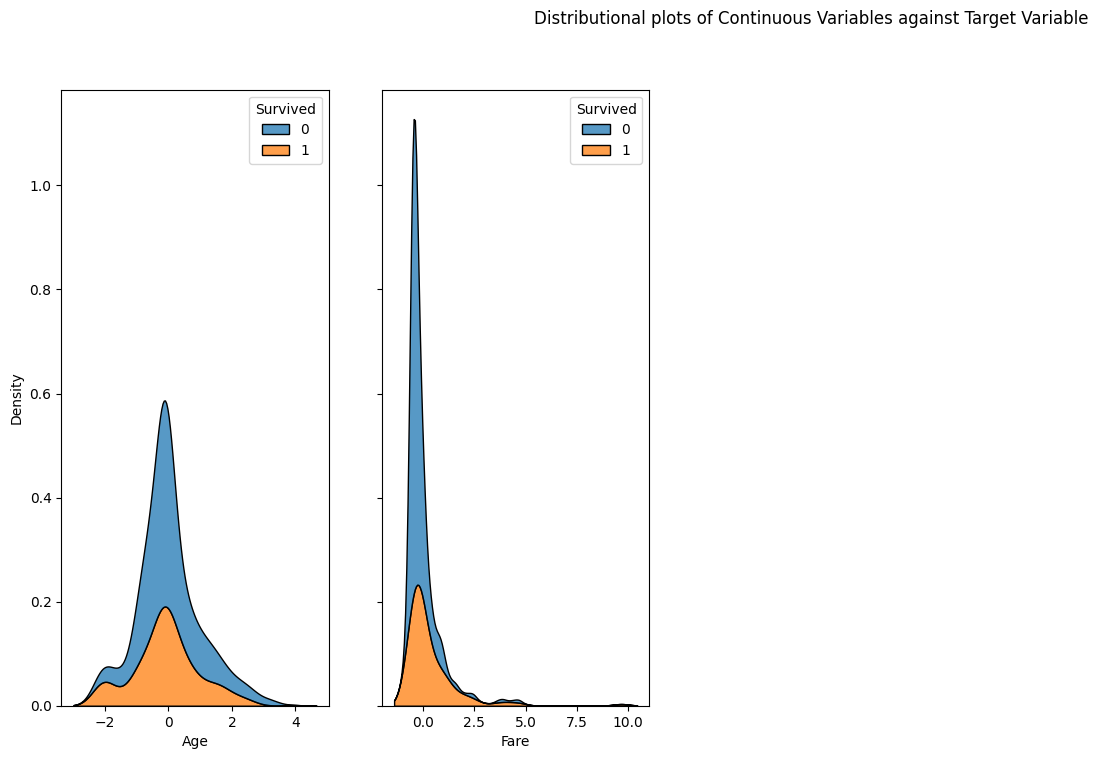

In [48]:
cts_variables = X7.select_dtypes(include=['float']).columns.tolist()
X7_df = X7.copy()
X7_df['Survived'] = y
# Calculate the number of rows and columns needed for the subplots
n = len(cts_variables)
cols = 5
rows = int(np.ceil(n / cols))

# Create a figure with the subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 8), sharey=True)
if rows == 1:
    axs = axs.reshape(1, cols)

# Iterate over the dataframes and create a crosstab plot for each one
for i in np.arange(0,n):
    # Get the index of the subplot
    row = i // cols # row : quotient
    col = i % cols  # col : remainder

    # Create the distributional plot in the subplot
    sns.kdeplot(data=X7_df, x=cts_variables[i], hue=target_var, ax=axs[row, col], multiple='stack');

for j in np.arange(n%cols,cols):
    axs[n//cols,j].set_visible(False)

# Add a title to the figure
fig.suptitle('Distributional plots of Continuous Variables against Target Variable')

# Show the plot
plt.show()

In [131]:
# Brunner-Munzel test (non-parametic & non-equal variances extension of two-sample t-test)
# For multiple response variables
import pandas as pd
import scipy.stats

# Load the data
alpha = 0.05
data = X7_df[cts_variables]
groups = X7_df[target_var]

# Initialize an empty list to store the results
hyp_test_results = []

# Iterate over the columns in the dataframe
for col in data.columns:
    # Extract the response variable and the group labels
    y = data[col]

    # Conduct the Brunner-Munzel test
    statistic, p_value = scipy.stats.brunnermunzel(y[groups == 0], y[groups == 1])

    # Append the results to the list
    hyp_test_results.append({'Response Cts variable': col, 'Test Statistic': statistic, 'p-value': p_value, 'Distributions Statistically Different?': (p_value<alpha)})

# Convert the list to a dataframe
hyp_test_results_df = pd.DataFrame(hyp_test_results)

# Print the results
hyp_test_results_df.sort_values('p-value', ascending=True)

,Response Cts variable,Test Statistic,p-value,Distributions Statistically Different?
1,Fare,10.617691,0.000000,True
0,Age,-1.079143,0.280935,False


In [135]:
print(hyp_test_results_df.sort_values('p-value', ascending=True)[hyp_test_results_df['Distributions Statistically Different?']==True]['Response Cts variable'].to_list(),)

['Fare']


Boolean Series key will be reindexed to match DataFrame index.


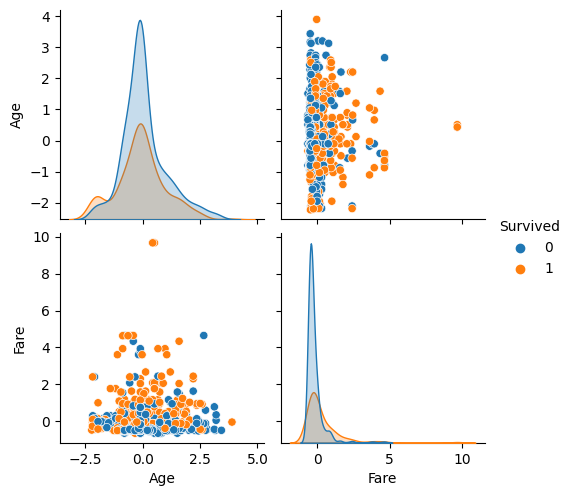

In [49]:
sns.pairplot(X7_df, hue='Survived')

### ------Categorical Variable Crosstab Analysis with respect to target variable
Crosstabs plots for categorical variables with respect to target variable

<Figure size 2000x3200 with 0 Axes>

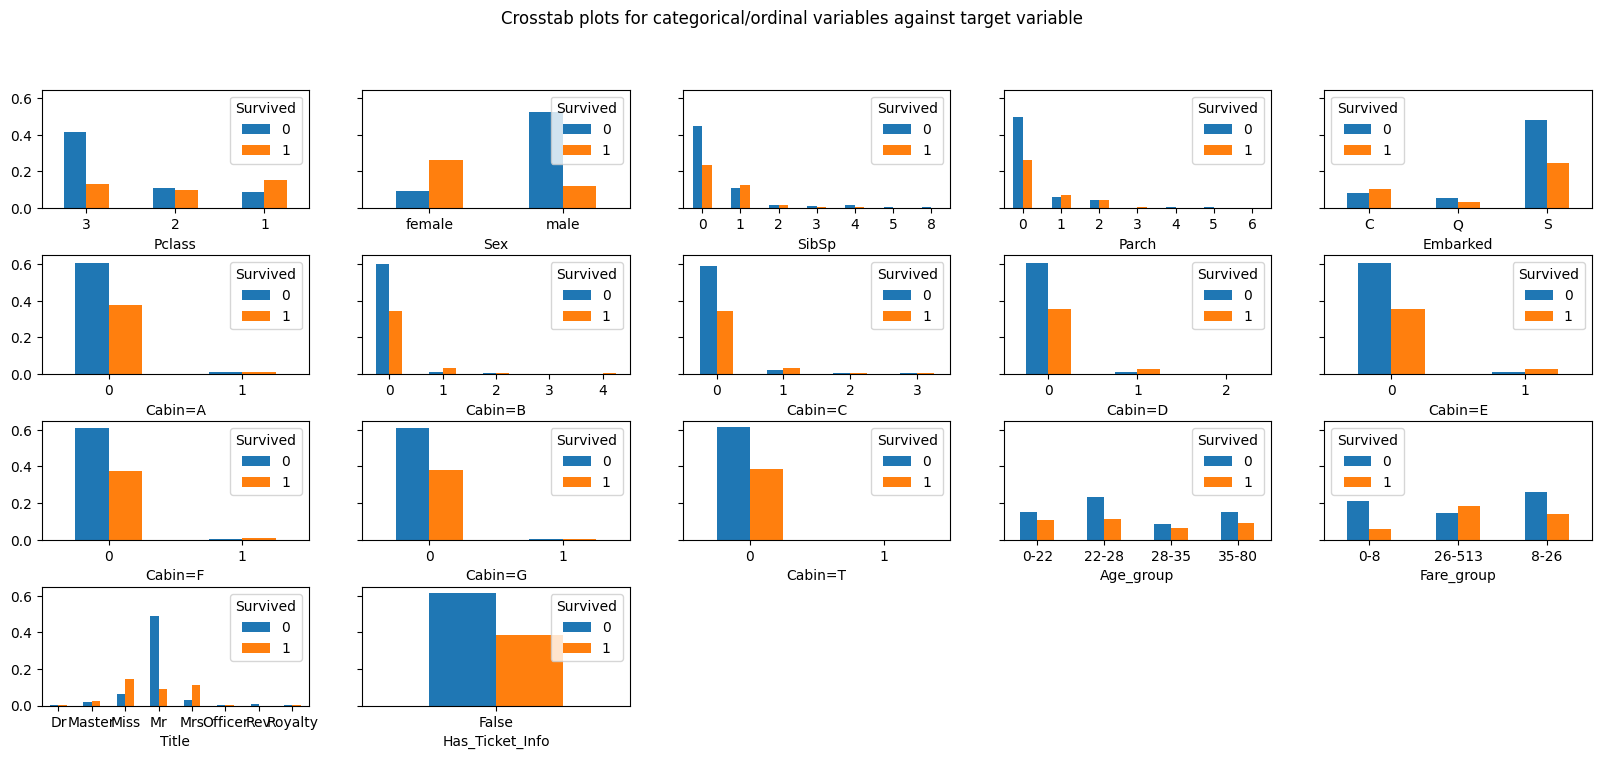

In [50]:
cat_ord_vars = X7.select_dtypes(include=['category']).columns.tolist()
plt.figure(figsize=(20, 32));
# Calculate the number of rows and columns needed for the subplots
n = len(cat_ord_vars)
rows = int(np.ceil(n / 5))
cols = 5

# Create a figure with the subplots
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 8), sharey=True);
if rows == 1:
    axs = axs.reshape(1,cols)

# Iterate over the dataframes and create a crosstab plot for each one

for i in np.arange(0, n):
    # Get the index of the subplot
    row = i // cols # row : quotient
    col = i % cols  # col : remainder

    # Create the crosstab plot in the subplot
    pd.crosstab(X7_df[cat_ord_vars[i]], X7_df[target_var], normalize=True).plot(kind='bar', ax=axs[row, col], rot=0);

for j in np.arange(n%cols,cols):
    axs[n//cols,j].set_visible(False);

plt.xticks(fontsize=2, rotation=0);

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4);
# Add a title to the figure
fig.suptitle('Crosstab plots for categorical/ordinal variables against target variable');

# Show the plot
plt.show();

Chi-square test of independence for a pair of categorical variables

To test the independence between two categorical/ordinal variables, one can use the `chi2_contingency` function from the scipy.stats library. This function calculates the chi-square statistic and p-value for the test of independence of two categorical variables.

Here we use `chi2_contingency` to test the association/non-independence between a categorical/ordinal variable against the target variable in Python:

In [127]:
import scipy.stats
import pandas as pd

# Load the data
data = X7_df[cat_ord_vars]
target = X7_df[target_var]

alpha = 0.05

# Initialize an empty list to store the results
results = []

# Iterate over the pairs of columns in the dataframe
for col1 in data.columns:
    # Extract the categorical variables
    var1 = data[col1]
    
    # Conduct the chi-square test of independence
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(pd.crosstab(var1, target))

    # Append the results to the list
    results.append({'Categorical/Ordinal Variable': col1, 'Target Variable': target_var, 'Chi-square statistic': chi2_stat, 'p-value': p_value, 'Association Statistically Significant?': (p_value<alpha)})

# Convert the list to a dataframe
results_df = pd.DataFrame(results)

# Print the results
results_df.sort_values('p-value', ascending=True)

,Categorical/Ordinal Variable,Target Variable,Chi-square statistic,p-value,Association Statistically Significant?
15,Title,Survived,292.782423,2.102543e-59,True
1,Sex,Survived,260.717020,1.197357e-58,True
0,Pclass,Survived,102.888989,4.549252e-23,True
14,Fare_group,Survived,68.705982,1.204164e-15,True
2,SibSp,Survived,37.271793,1.558581e-06,True
4,Embarked,Survived,25.964453,2.300863e-06,True
6,Cabin=B,Survived,28.405702,1.032061e-05,True
9,Cabin=E,Survived,18.631492,1.585793e-05,True
8,Cabin=D,Survived,20.495503,3.543708e-05,True
3,Parch,Survived,27.925784,9.703526e-05,True


In [134]:
print(results_df.sort_values('p-value', ascending=True)[results_df['Association Statistically Significant?']==True]['Categorical/Ordinal Variable'].to_list(),)

['Title', 'Sex', 'Pclass', 'Fare_group', 'SibSp', 'Embarked', 'Cabin=B', 'Cabin=E', 'Cabin=D', 'Parch', 'Cabin=C']


Boolean Series key will be reindexed to match DataFrame index.


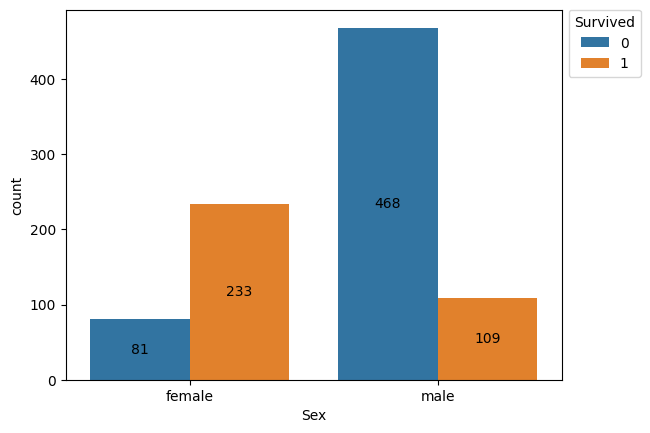

In [51]:
ax = sns.countplot(data=X7_df, x='Sex', hue='Survived', order=['female', 'male'])
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')

for c in ax.containers:
    
    # set the bar label
    ax.bar_label(c, label_type='center')

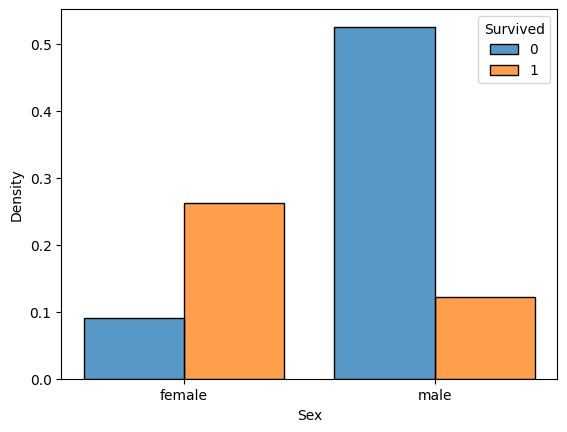

In [52]:
ax = sns.histplot(x = X7_df['Sex'], hue=X7_df['Survived'], multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=True)

### ------Hypotheses - which are the main predictor variables that influence the target variable ?

Based on the univariate variable analysis against the target variable, it appears that the main predictor variables that distinguish the target variable 'Survived' into its binary classes ('0'- Not Survived and '1'-Survived)
are 'Sex' (which is correlated with 'Title'), 'PClass'. Interestingly, 'Age' and 'Fare' distributional plots do not appear to separate the two classes. 

We shall next validate this hypothesis against analysis of feature importances later.

## 1.8. Dictifier

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
# Define Dictifier class from sklearn.base  BaseEstimator, TransformerMixin submodules 
# to turn df into dictionary as part of pipeline
# Using Custom scikit-learn transformers for Data Processing / Feature Engineering
# https://www.andrewvillazon.com/custom-scikit-learn-transformers/
class Dictifier(BaseEstimator, TransformerMixin):
    """Converts a DataFrame or list of dictionaries to a list of dictionaries.
    
    Parameters
    ----------
    None
    
    Attributes
    ----------
    None
    
    Methods
    -------
    fit(self, X, y=None)
        Fits the transformer to the data.
        
        Parameters
        ----------
        X : pd.DataFrame or list of dictionaries
            The input data to fit.
            
        y : any, optional
            Ignored.
            
        Returns
        -------
        self : Dictifier object
            The fitted transformer.
            
    transform(self, X)
        Transforms the input data to a list of dictionaries.
        
        Parameters
        ----------
        X : pd.DataFrame or list of dictionaries
            The input data to transform.
            
        Returns
        -------
        list of dictionaries which each dictionary corresponding to a row of the input dataframe X
        with its keys, values containing the columns, and colume variable values respectively.

    Examples
    -------
    >>> X = pd.DataFrame({'Age': np.array([20, 30]), 'Pclass': np.array([3,1])})
    >>> dictifier_class = Dictifier()
    >>> print(dictifier_class.fit_transform(X))
    [{'Age': 20, 'Pclass': 3}, {'Age': 30, 'Pclass': 1}]

    """     
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if type(X) == pd.core.frame.DataFrame:
            return X.to_dict("records")
        else:
            return pd.DataFrame(X).to_dict("records")

In [54]:
dictifier_class = Dictifier()
X8 = dictifier_class.fit_transform(X7)
X_df_test8 = dictifier_class.transform(X_df_test7)

In [55]:
X8

[{'Age': -0.5657364610748746,
  'Fare': -0.5024451714361923,
  'Pclass': 3,
  'Sex': 'male',
  'SibSp': 1,
  'Parch': 0,
  'Embarked': 'S',
  'Cabin=A': 0,
  'Cabin=B': 0,
  'Cabin=C': 0,
  'Cabin=D': 0,
  'Cabin=E': 0,
  'Cabin=F': 0,
  'Cabin=G': 0,
  'Cabin=T': 0,
  'Age_group': '0-22',
  'Fare_group': '0-8',
  'Title': 'Mr',
  'Has_Ticket_Info': False},
 {'Age': 0.6638610320657843,
  'Fare': 0.7868452935884461,
  'Pclass': 1,
  'Sex': 'female',
  'SibSp': 1,
  'Parch': 0,
  'Embarked': 'C',
  'Cabin=A': 0,
  'Cabin=B': 0,
  'Cabin=C': 1,
  'Cabin=D': 0,
  'Cabin=E': 0,
  'Cabin=F': 0,
  'Cabin=G': 0,
  'Cabin=T': 0,
  'Age_group': '35-80',
  'Fare_group': '26-513',
  'Title': 'Mrs',
  'Has_Ticket_Info': False},
 {'Age': -0.2583370877897099,
  'Fare': -0.4888542575852486,
  'Pclass': 3,
  'Sex': 'female',
  'SibSp': 0,
  'Parch': 0,
  'Embarked': 'S',
  'Cabin=A': 0,
  'Cabin=B': 0,
  'Cabin=C': 0,
  'Cabin=D': 0,
  'Cabin=E': 0,
  'Cabin=F': 0,
  'Cabin=G': 0,
  'Cabin=T': 0,
  'Ag

In [56]:
X_df_test8

[{'Age': 0.3948865804412651,
  'Fare': -0.49078316061772326,
  'Pclass': 3,
  'Sex': 'male',
  'SibSp': 0,
  'Parch': 0,
  'Embarked': 'Q',
  'Cabin=A': 0,
  'Cabin=B': 0,
  'Cabin=C': 0,
  'Cabin=D': 0,
  'Cabin=E': 0,
  'Cabin=F': 0,
  'Cabin=G': 0,
  'Cabin=T': 0,
  'Age_group': '28-35',
  'Fare_group': '0-8',
  'Title': 'Mr',
  'Has_Ticket_Info': False},
 {'Age': 1.3555096219574048,
  'Fare': -0.5074788432328381,
  'Pclass': 3,
  'Sex': 'female',
  'SibSp': 1,
  'Parch': 0,
  'Embarked': 'S',
  'Cabin=A': 0,
  'Cabin=B': 0,
  'Cabin=C': 0,
  'Cabin=D': 0,
  'Cabin=E': 0,
  'Cabin=F': 0,
  'Cabin=G': 0,
  'Cabin=T': 0,
  'Age_group': '35-80',
  'Fare_group': '0-8',
  'Title': 'Mrs',
  'Has_Ticket_Info': False},
 {'Age': 2.5082572717767726,
  'Fare': -0.4533668714188957,
  'Pclass': 2,
  'Sex': 'male',
  'SibSp': 0,
  'Parch': 0,
  'Embarked': 'Q',
  'Cabin=A': 0,
  'Cabin=B': 0,
  'Cabin=C': 0,
  'Cabin=D': 0,
  'Cabin=E': 0,
  'Cabin=F': 0,
  'Cabin=G': 0,
  'Cabin=T': 0,
  'Age_gr

## 1.9. CountVectorizer:  Final stage of Dataprocessing Pipeline

Within `final_data_processing_pipeline`, the last step `DictVectorizer()` transforms input dataframe (from the output of step `Dictifier()`) into `X_pipeline`, which is a compressed sparse row (csr) format matrix of type `<class 'numpy.float64>`.

The feature names of the output dataframe from step `Dictifier()` (just prior to DictVectorizer) can be obtained by invoking the command:

```X_feature_names = list(final_data_processing_pipeline[-1].get_feature_names_out())```.

In [57]:
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
df = pd.read_csv('../data/raw/train.csv')
# Drop any duplicate rows
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

target_var = 'Survived'
id_var = 'PassengerId'
labelencoder = LabelEncoder()
df[target_var] = labelencoder.fit_transform(df[target_var])
df[target_var] = df[target_var].astype('category')
y = df[target_var].to_numpy().ravel()

df = df.drop([id_var,target_var], axis=1)
float_columns = ['Age', 'Fare']
categorical_columns = list(df.drop(float_columns, axis=1).columns)

final_data_processing_pipeline = Pipeline(
    steps=[
        ("Preprocess_Data", DataPreprocessingClass()),
        ("Feature_Union_Imputer", DataframeFeatureImputerUnion()),
        ("Process_Text", TextProcessingClass()),
        ("Cts_Var_FeatureEng", ContinuousFeatureEngineering()),
        ("Cat_Var_Feature_Eng", CategoricalFeatureEngineering()),
        ("Finalize_Feature_Vars", FinalizeFeatureVars()),
        ("Scale_Float_Vars", DataframeFeatureScalerUnion()),
        ("Dictifier", Dictifier()),
        ("Dict_Vectorizer", DictVectorizer(sort=False))
        ]
)
X_pipeline = final_data_processing_pipeline.fit_transform(df)

/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False

In [58]:
X_feature_names = list(final_data_processing_pipeline[-1].get_feature_names_out())
print(type(X_pipeline),'\n', X_feature_names,)

<class 'scipy.sparse._csr.csr_matrix'> 
 ['Age', 'Fare', 'Pclass', 'Sex=male', 'SibSp', 'Parch', 'Embarked=S', 'Cabin=A', 'Cabin=B', 'Cabin=C', 'Cabin=D', 'Cabin=E', 'Cabin=F', 'Cabin=G', 'Cabin=T', 'Age_group=0-22', 'Fare_group=0-8', 'Title=Mr', 'Has_Ticket_Info', 'Sex=female', 'Embarked=C', 'Age_group=35-80', 'Fare_group=26-513', 'Title=Mrs', 'Age_group=22-28', 'Title=Miss', 'Age_group=28-35', 'Fare_group=8-26', 'Embarked=Q', 'Title=Master', 'Title=Royalty', 'Title=Rev', 'Title=Dr', 'Title=Officer']


In [59]:
X_pipeline_df = pd.DataFrame(X_pipeline.toarray(), columns=X_feature_names)
X_pipeline_df['Survived'] = y

In [60]:
df_test = pd.read_csv('../data/raw/test.csv')
df_test = df_test.drop([id_var], axis=1)
X_df_test_pipeline = final_data_processing_pipeline.transform(df_test)

In [61]:
X_df_test_pipeline.toarray().dtype, pd.DataFrame(X_df_test_pipeline.toarray()).isnull().sum().sum()

(dtype('float64'), 0)

In [62]:
print(dir(final_data_processing_pipeline),)

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_can_inverse_transform', '_can_transform', '_check_feature_names', '_check_fit_params', '_check_n_features', '_estimator_type', '_final_estimator', '_fit', '_get_param_names', '_get_params', '_get_tags', '_iter', '_log_message', '_more_tags', '_pairwise', '_replace_estimator', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_params', '_sk_visual_block_', '_validate_data', '_validate_names', '_validate_steps', 'classes_', 'decision_function', 'feature_names_in_', 'fit', 'fit_

### ------ Correlation Analysis for EDA and end of EDA---------------



In [63]:
import phik 
from phik import resources, report
df_dummies = pd.DataFrame(X_pipeline.toarray(), columns=X_feature_names)
df_dummies['Survived'] = y
df_phik_matrix = df_dummies.phik_matrix(interval_cols=cts_variables)

/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Has_Ticket_Info for analysis 1. Dropping this column
  warnings.warn(


In [64]:
np.round(df_phik_matrix[['Survived']].sort_values(by='Survived', ascending=False, axis=0).iloc[1:21,:].T,3)

,Title=Mr,Sex=female,Sex=male,Title=Mrs,Title=Miss,Fare_group=26-513,Fare_group=0-8,Fare,Embarked=C,Embarked=S,Cabin=E,Age,Pclass,SibSp,Cabin=C,Parch,Cabin=B,Title=Master,Age_group=22-28,Cabin=D
Survived,0.756,0.75,0.75,0.505,0.497,0.382,0.317,0.265,0.252,0.223,0.219,0.207,0.205,0.176,0.152,0.147,0.136,0.113,0.108,0.087


In [65]:
np.round(df_phik_matrix[['Title=Mr']].sort_values(by='Title=Mr', ascending=False, axis=0).iloc[1:21,:].T,3)

,Sex=female,Sex=male,Title=Miss,Survived,Title=Mrs,Age,Fare_group=0-8,Title=Master,Parch,Fare_group=26-513,SibSp,Age_group=0-22,Age_group=22-28,Embarked=S,Fare,Title=Dr,Title=Rev,Embarked=Q,Title=Officer,Title=Royalty
Title=Mr,0.978,0.978,0.808,0.756,0.676,0.434,0.401,0.379,0.354,0.307,0.289,0.273,0.17,0.164,0.158,0.134,0.119,0.104,0.102,0.102


In [66]:
np.round(df_phik_matrix[['Fare']].sort_values(by='Fare', ascending=False, axis=0).iloc[1:21,:].T,3)

,Cabin=C,Fare_group=26-513,Pclass,Cabin=B,SibSp,Fare_group=8-26,Parch,Survived,Embarked=C,Cabin=D,Fare_group=0-8,Age,Sex=male,Sex=female,Cabin=E,Embarked=S,Title=Mr,Title=Mrs,Age_group=35-80,Title=Miss
Fare,0.677,0.612,0.588,0.582,0.498,0.347,0.337,0.265,0.256,0.255,0.255,0.185,0.177,0.177,0.161,0.158,0.158,0.155,0.151,0.107


/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Has_Ticket_Info for analysis 1. Dropping this column
  warnings.warn(


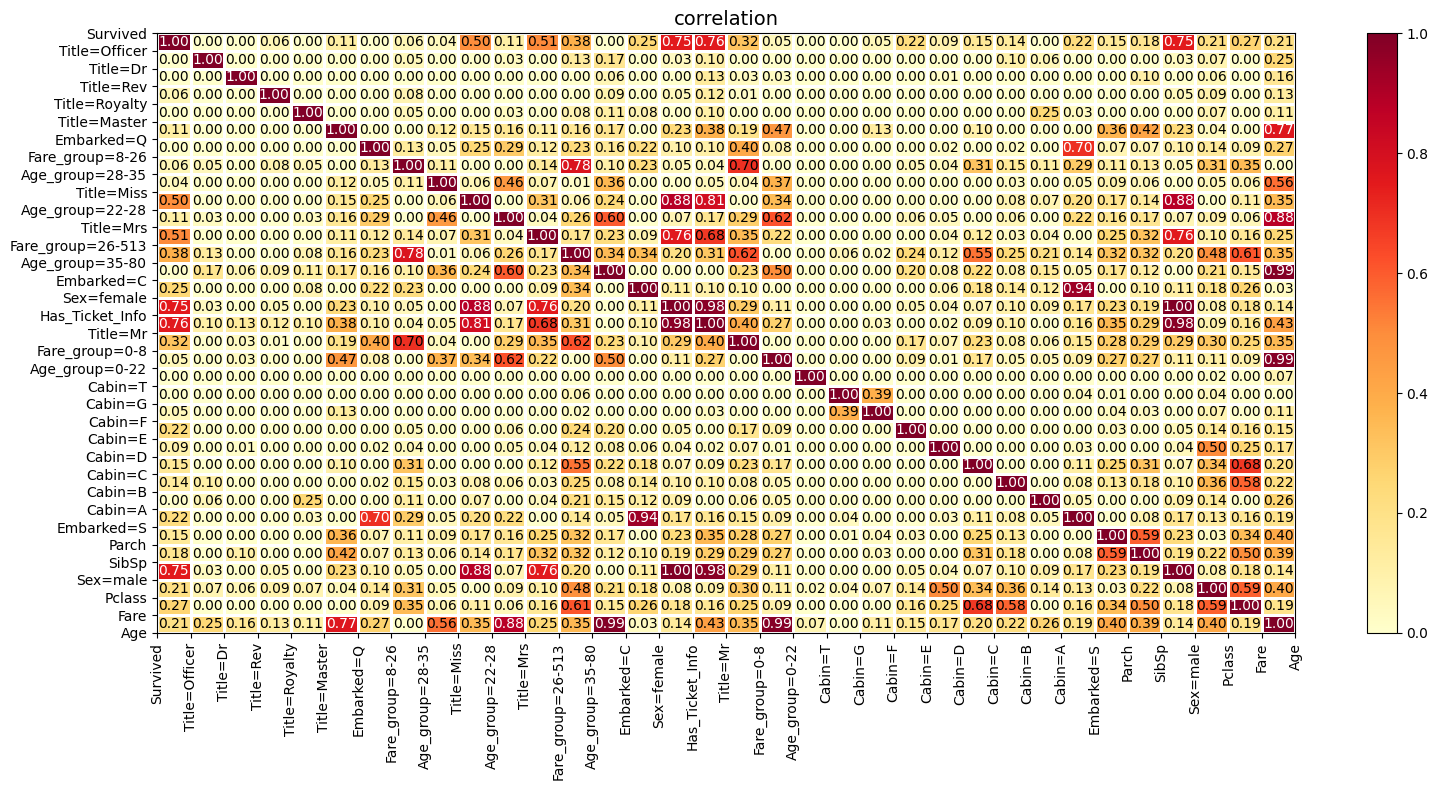

In [67]:
df_dummies_phik_matrix = df_dummies.phik_matrix(interval_cols=cts_variables)
phik.report.plot_correlation_matrix(df_dummies_phik_matrix.values, x_labels=list(df_dummies.columns), y_labels=list(df_dummies.columns), print_both_numbers=False, figsize=(16,8), vmin=0, vmax=1, color_map='YlOrRd')
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

# 2.Classification Pipelines for Training - XGboost, LogisticRegression L1, RandomForest, DecisionTreeClassifier, KNeighborsClassifier, LightGBM, Random Forest


In [68]:
# Using pickle to save & model models (faster but less secure) https://mljar.com/blog/save-load-scikit-learn-model/
import pickle
import joblib
import scipy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [69]:
# Create the parameter grids for each classification algorithm to be used
xgb_param_grid = {
    'clf__learning_rate': np.arange(0.05, 1.00, 0.05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 200, 50)
    }

lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
    }

dt_param_grid = {
    'clf__max_depth': [2, 3, 5, 10],
    'clf__min_samples_leaf': [5, 10, 20, 50],
    'clf__criterion': ["gini", "entropy"]
    }

knn_param_grid = {
    'clf__n_neighbors': list(range(1, 31))
    }

lgb_param_grid = {
    'clf__learning_rate': [0.01, 0.1, 1],
    'clf__n_estimators': [100, 500, 1000],
    'clf__max_depth': [3, 5, 7],
    'clf__num_leaves': [31, 63, 127],
    'clf__lambda_l1': [0, 0.1, 1],
    'clf__lambda_l2': [0, 0.1, 1]
}

ctb_param_grid = {
    'clf__depth': [4, 6, 8],
    'clf__learning_rate': [0.01, 0.02, 0.04],
    'clf__iterations': [10, 20, 30]
                 }

rf_param_grid = { 
    'clf__n_estimators': [200, 400],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth' : [4,6,8],
    'clf__criterion' :['gini', 'entropy']
}

In [70]:
pipelines = []
pipelines.append(('XGB', Pipeline([('clf', XGBClassifier(max_depth=3, tree_method="gpu_hist", enable_categorical=True))]), xgb_param_grid))
pipelines.append(('LR', Pipeline([('clf', LogisticRegression(max_iter=2000, tol=0.001))]), lr_param_grid))
pipelines.append(('DT', Pipeline([('clf', DecisionTreeClassifier())]), dt_param_grid))
pipelines.append(('LGBM', Pipeline([('clf', LGBMClassifier())]), lgb_param_grid))
pipelines.append(('CatB', Pipeline([('clf', CatBoostClassifier())]), ctb_param_grid))
pipelines.append(('KNN', Pipeline([('clf', KNeighborsClassifier())]), knn_param_grid))
pipelines.append(('RF', Pipeline([('clf', RandomForestClassifier())]), rf_param_grid))

cv_folds = 5
n_iter = 20
scoring = "roc_auc"

model_name = []
results = []
records = []
X_train, X_test, y_train, y_test = train_test_split(X_pipeline, y, test_size=0.2, random_state=42)
for pipename , pipeline, param_grid in pipelines:
    rs_cv = RandomizedSearchCV(estimator=pipeline, cv=cv_folds, n_iter=n_iter, scoring=scoring, verbose=1, param_distributions=param_grid)
    rs_cv.fit(X_train, y_train)
    crosscv_results = rs_cv.cv_results_['mean_test_score']
    model_filename = pipename + '_' + scoring + '_rs_cv_model.sav'
    # save model with pickle
    pickle.dump(rs_cv, open(model_filename, 'wb'))
    filename = pipename + '_' + scoring + "_rs_cv_model.joblib"
    # save model with joblib
    joblib.dump(rs_cv, filename)
    results.append(crosscv_results)
    model_name.append(pipename)
    msg = "%s: Score Mean %f , Score Std (%f)" % (model_name, crosscv_results.mean(), crosscv_results.std())
    print(msg)
    records.append((model_name, crosscv_results.mean(), crosscv_results.std()))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
['XGB']: Score Mean 0.851376 , Score Std (0.006504)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
['XGB', 'LR']: Score Mean 0.831232 , Score Std (0.086004)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
['XGB', 'LR', 'DT']: Score Mean 0.834761 , Score Std (0.012924)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignor

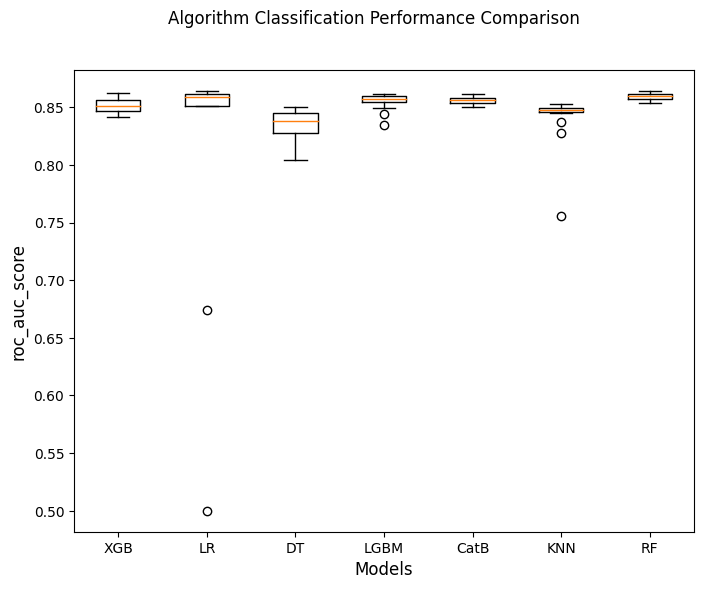

In [71]:
# Compare different Algorithms
fig = plt.figure(figsize=[6.4*1.25, 4.8*1.25])
fig.suptitle('Algorithm Classification Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_name)
plt.xlabel("Models", fontsize=12)
plt.ylabel(scoring+"_score", fontsize=12)
plt.show()

# 3.Analysis of overall Train-Test prediction performances across different metrics

- Although RandomForest Classifier (RF) and CatBoost appears to be the top two classifiers on train results, they have a larger performace gap relative to XgBoost (XGB) and the L1-regularized Logistic Regession (LR) models on validation dataset results for the AUC metric. 

- Overall, the XGB and LR models are the top 2 models across most metrics on validation dataset results. 

- Notably, the Decision Tree Classifier (DT) and K-Nearest Neighbours classifer (KNN) appear to be the top 2 worst classifers in terms of overall performances across most metrics on validation dataset results.

Let us now focus on the top 2 performing models (XGB & LR) to perform further analyses on their respective top ranked feature importances that influence the models' classification predictions (in the case of Titanic dataset, its prediction of survivability).

In the appendix, we shall place similar analyses of the other models for the interested reader.

In [72]:
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, matthews_corrcoef
model_preds = [pickle.load(open(model+'_roc_auc_rs_cv_model.sav','rb')).predict(X_test) for model in model_name]
models_dict = dict(zip(model_name, model_preds))
# Create a dictionary to store the performance metrics for each model
metrics = {}

# Calculate the performance metrics for each model
for name, y_pred in models_dict.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    metrics[name] = {
        'Accuracy': report['accuracy'],
        'AUC': roc_auc_score(np.array(y_test), y_pred),
        'Recall': report['macro avg']['recall'],
        'Prec.': report['macro avg']['precision'],
        'F1': report['macro avg']['f1-score'],
        'Kappa': cohen_kappa_score(np.array(y_test), y_pred),
        'MCC': matthews_corrcoef(np.array(y_test), y_pred),
    }

# Create a DataFrame from the metrics dictionary
clf_report_df = np.round(pd.DataFrame.from_dict(metrics, orient='index'),3)

train_results_means = np.array([records[i][1] for i in range(0,len(model_name))])
train_results_std = np.array([records[i][2] for i in range(0,len(model_name))])
scr = scoring.upper().split('_')[1]

# Combing train and test prediction overall results as a dataframe, train_test_results_df
train_results_df = np.round(pd.DataFrame({scr+' Mean':train_results_means, scr+' Std':train_results_std}, index=model_name),3)
train_results_df.columns = pd.MultiIndex.from_product([['Train_Results'], train_results_df.columns])
clf_report_df.columns = pd.MultiIndex.from_product([['Validation_Results'], clf_report_df.columns])
train_test_results_df = pd.concat([train_results_df, clf_report_df], axis = 1)

# Save the train_test_results_df dataframe train-test-prediction results to a CSV file
train_test_results_df.to_csv('classification_comparison_report.csv', index=True)

/home/aiventurer/cookiecutter/cookiecutter-data-science-template-[Titanic]/Classification_Titanic/venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [73]:
train_test_results_df

Train_Results         Validation_Results                              \
          AUC Mean AUC Std           Accuracy    AUC Recall  Prec.     F1   
XGB          0.851   0.007              0.821  0.808  0.808  0.821  0.812   
LR           0.831   0.086              0.821  0.816  0.816  0.816  0.816   
DT           0.835   0.013              0.804  0.797  0.797  0.799  0.798   
LGBM         0.855   0.006              0.816  0.807  0.807  0.811  0.809   
CatB         0.856   0.003              0.821  0.812  0.812  0.817  0.814   
KNN          0.842   0.021              0.788  0.771  0.771  0.786  0.776   
RF           0.859   0.003              0.827  0.816  0.816  0.824  0.820   

                    
      Kappa    MCC  
XGB   0.625  0.628  
LR    0.631  0.631  
DT    0.596  0.596  
LGBM  0.618  0.618  
CatB  0.628  0.629  
KNN   0.553  0.557  
RF    0.639  0.640

## 3.1. Top performing model - XGBoost
 - Classification report
 - Confusion matrix
 - Top 10 feature importances of XGboost model ranked by
    - XGBoost model itself
    - SHAP

In [74]:
xgb_auc_model = pickle.load(open('XGB_roc_auc_rs_cv_model.sav','rb'))
y_pred = xgb_auc_model.predict(X_test)
xgb_auc_clf_report = classification_report(y_test, y_pred, output_dict=True)
xgb_auc_clf_df = pd.DataFrame(xgb_auc_clf_report).transpose()

In [75]:
xgb_auc_clf_df

,precision,recall,f1-score,support
0,0.823009,0.885714,0.853211,105.000000
1,0.818182,0.729730,0.771429,74.000000
accuracy,0.821229,0.821229,0.821229,0.821229
macro avg,0.820595,0.807722,0.812320,179.000000
weighted avg,0.821013,0.821229,0.819402,179.000000


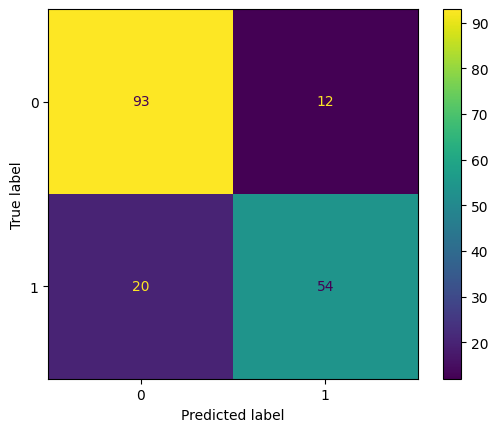

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=xgb_auc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_auc_model.classes_)
disp.plot()
plt.show()

### 3.1.0. Groups of Correlated Features from EDA

Recall from EDA, the top 3 groups of correlated features are as follows:
- 'Title=Mr', 'Sex=Male', 'Sex=Female', 'Title=Mrs', 'Title=Miss'
- 'Pclass', 'Fare', 'Fare_groups=x'
- 'Age', 'Title=Master', 


We shall keep them in mind whilst analyzing the top 10 feature importances ranked by Xgboost model itself, and the SHAP algorithm.

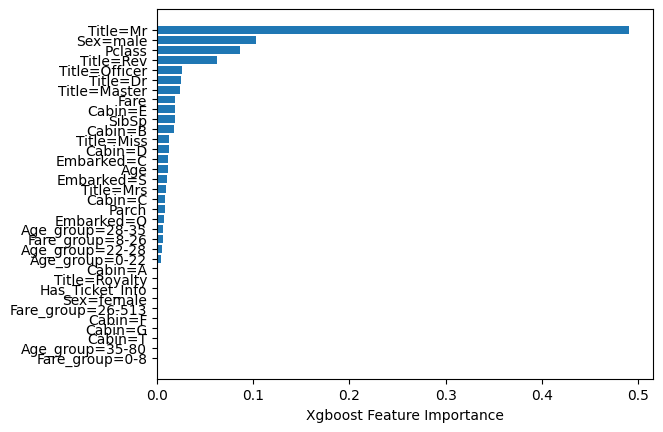

In [77]:
sorted_idx1 = xgb_auc_model.best_estimator_.named_steps["clf"].feature_importances_.argsort()
plt.barh(final_data_processing_pipeline.named_steps["Dict_Vectorizer"].get_feature_names_out()[sorted_idx1], xgb_auc_model.best_estimator_.named_steps["clf"].feature_importances_[sorted_idx1]);
plt.xlabel("Xgboost Feature Importance");

### 3.1.1. Model ranked Feature Importances
According to the Xgboost model, the top groups of features (taking in account the groups of correlated features) are 
1. (Title=Mr, Sex=Male, Title=Rev)
2. (Pclass and Fare, Fare_group=8-26)

Interestingly, the Xgboost model attaches little to no feature importance to features such as 'Age', '(Title=Mrs, Sex=female)', 'Parch'.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


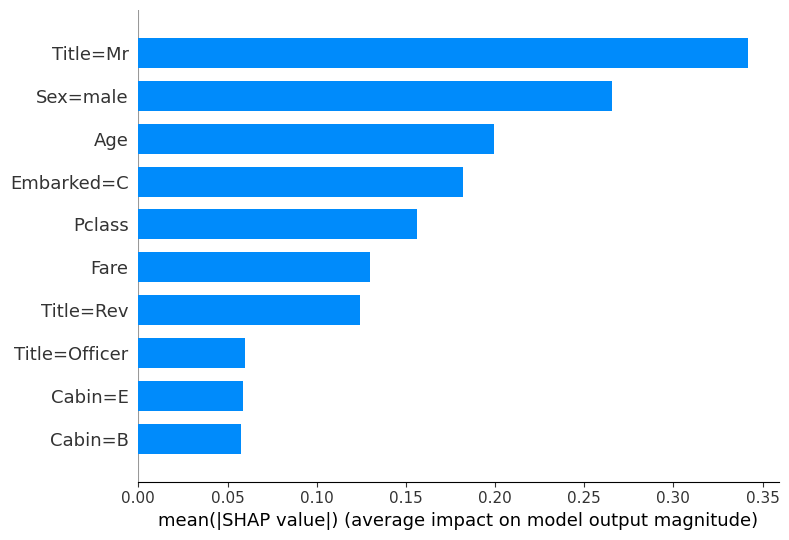

In [78]:
import shap
xgb_auc_explainer = shap.TreeExplainer(xgb_auc_model.best_estimator_.named_steps["clf"])
xgb_auc_shap_values = xgb_auc_explainer.shap_values(X_pipeline.toarray())
X_df = pd.DataFrame(X_pipeline.toarray(), columns=X_feature_names)
shap.summary_plot(xgb_auc_shap_values, X_df, plot_type="bar", max_display=10);

### 3.1.2. SHAP-ranked Feature Importances
According to SHAP,  the top groups of features for XGB model (taking in account the groups of correlated features) are 
1. (Title=Mr, Sex=Male, Title=Rev, Title=Mrs)
2. (Pclass and Fare, Fare_group=8-26)
3. Age

In contrast to the Xgboost model feature importance self-rankings, SHAP ranks Pclass to have the 2nd highest average impact on model output magnitude for the Xgboost model.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


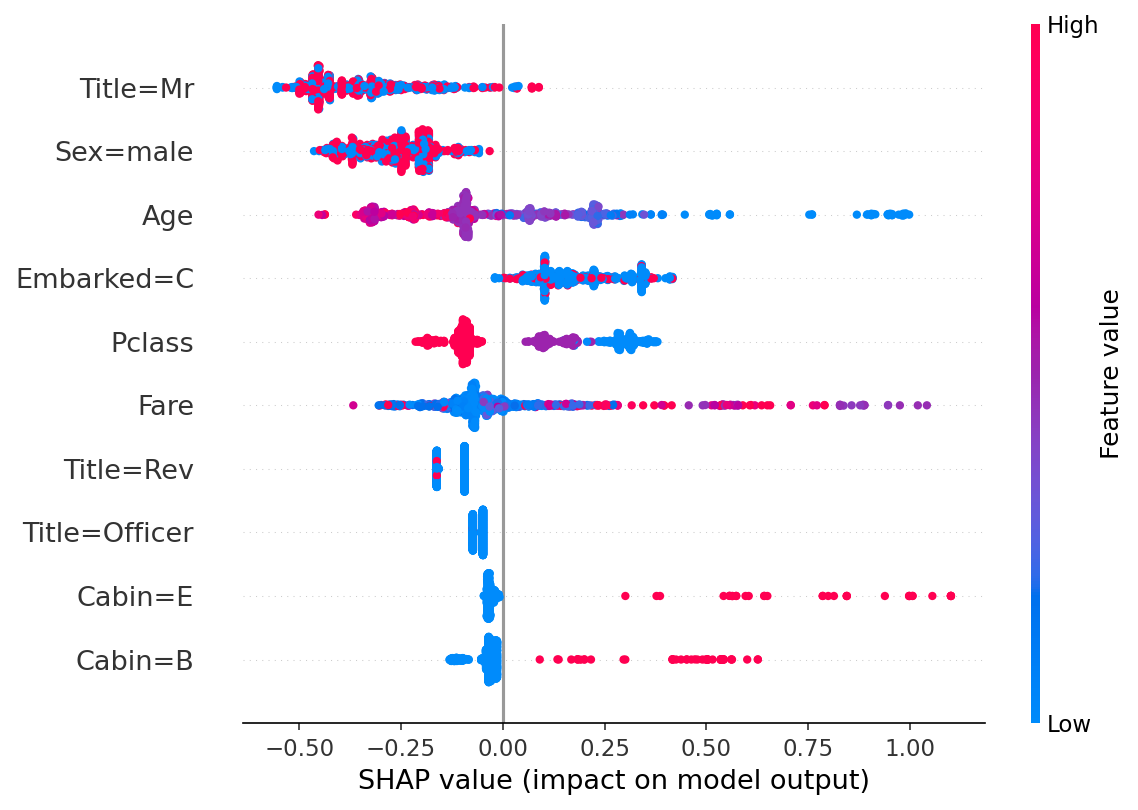

In [79]:
plt.figure(figsize=(10,6), dpi=150)
shap.summary_plot(xgb_auc_shap_values, X_pipeline.toarray(), feature_names=X_feature_names, max_display=10)
plt.show();

## 3.2.Second performing model - Logistic Regresssion (L1-regularized)

 - Classification report
 - Confusion matrix
 - Top 10 feature importances of XGboost model ranked by
    - XGBoost model itself
    - SHAP

In [80]:
lr_auc_model = pickle.load(open('LR_roc_auc_rs_cv_model.sav','rb'))
y_pred_lr = lr_auc_model.predict(X_test)
lr_auc_clf_report = classification_report(y_test, y_pred_lr, output_dict=True)
lr_auc_clf_df = pd.DataFrame(lr_auc_clf_report).transpose()

In [81]:
lr_auc_clf_df

,precision,recall,f1-score,support
0,0.847619,0.847619,0.847619,105.000000
1,0.783784,0.783784,0.783784,74.000000
accuracy,0.821229,0.821229,0.821229,0.821229
macro avg,0.815701,0.815701,0.815701,179.000000
weighted avg,0.821229,0.821229,0.821229,179.000000


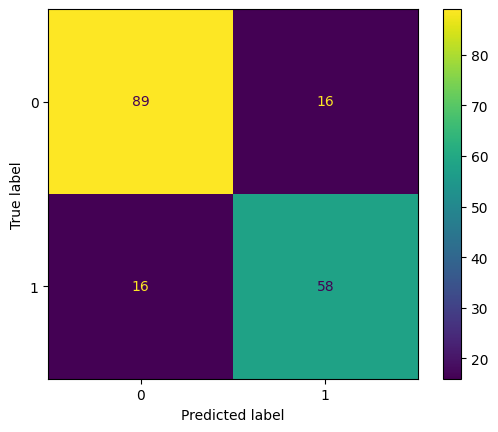

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
lr_cm = confusion_matrix(y_test, y_pred_lr, labels=lr_auc_model.classes_)
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr_auc_model.classes_)
lr_disp.plot()
plt.show()

### 3.2.1. Model ranked Feature Importances

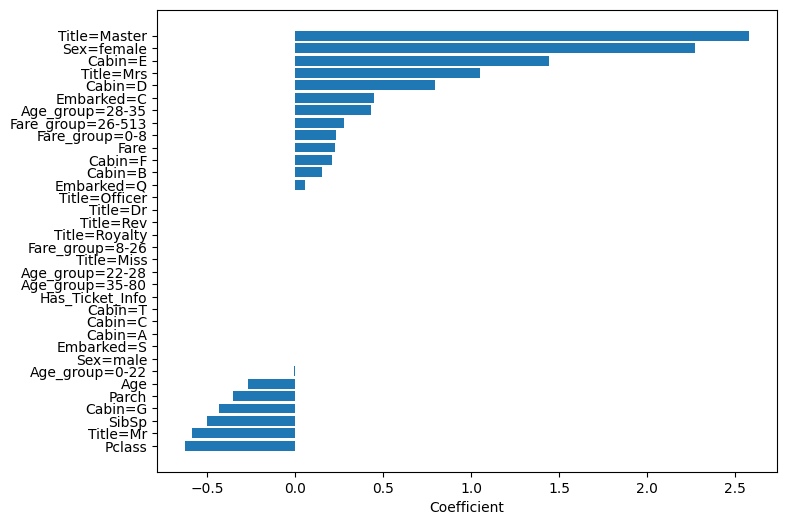

In [140]:
lr_model = pickle.load(open('LR_roc_auc_rs_cv_model.sav','rb'))
# Get the feature coefficients
coefficients = lr_model.best_estimator_.steps[-1][1].coef_[0]

# Sort the feature coefficients in descending order
sorted_coefficients = sorted(zip(X_feature_names, coefficients), key=lambda x: x[1], reverse=False)

# Get the top-ranked features
top_features = sorted_coefficients

# Extract the feature names and coefficients
feature_names, coefficients = zip(*top_features)

# Set the figure size
plt.figure(figsize=(8, 6))

# Draw a horizontal bar chart
plt.barh(feature_names, coefficients)

# Set the x-axis label
plt.xlabel('Coefficient')

# Show the plot
plt.show()

In [144]:
Odds_ratio_df = pd.DataFrame({'Feature': feature_names, \
    'LogReg Coefficient': np.round(coefficients,3), \
    'Odds-ratio': np.round(np.exp(coefficients),3)})

Odds_ratio_df[np.abs(Odds_ratio_df['LogReg Coefficient'])>0.2]

,Feature,LogReg Coefficient,Odds-ratio
0,Pclass,-0.626,0.535
1,Title=Mr,-0.586,0.557
2,SibSp,-0.502,0.605
3,Cabin=G,-0.436,0.646
4,Parch,-0.354,0.702
5,Age,-0.272,0.762
23,Cabin=F,0.210,1.234
24,Fare,0.225,1.253
25,Fare_group=0-8,0.231,1.260
26,Fare_group=26-513,0.278,1.320


In [148]:
intercept = lr_model.best_estimator_.steps[-1][1].intercept_
intercept, np.exp(intercept)

(array([0.08189391]), array([1.08534066]))

### 3.2.2. Interpretation of the Logistic Regression model coefficients in terms of Odds-ratios

It is well-known that the optimal coefficients $\beta:=\{\beta_{i} \}_{i=0}^{m}$ of the Logistic Regression model for the binary classification problem are obtained by minimizing the categorical cross-entropy function $l$ defined by $$l(\beta):= - \sum_{n}\left(  y_{n} \ln p_{n} + (1-y_{n}) \ln (1-p_{n}) \right), $$ where $y_{n} \in \{0,1\}$ and 

for a given row (data,target variable) = $(x_{n}, y_{n})$ with $x_{n}:=[x_{n,1} x_{n,2} \ldots  x_{n,m}]$

the functions $p_{n}$ are derived from the logistic function, i.e., $$p_{n}:=p(x_{n}):=p_{k}(\beta)(x) = [1+\exp(-\beta_{0}+\beta_{1}x_{n,1}+\ldots +\beta_{m}x_{n,m})]^{-1}.$$

Note that $n,m$ denote the number of rows of columns of data matrix $X$, where its nth row is equal to $x_{n}$, which has m columns.

The functions $p_{n}=P(y_{n}=1|X)$ can be interpreted as the respective probability of the $n$-th response/target binary variable taking the value $1$ (positive class) given the feature matrix $X$.

To interpret the effects of the coefficients that influence $p_{n}$, 
the odds ratio can be used, it simply measures how likely the positive class (1) to be occur compared to the negative class (0). The odds-ratio corrresponding to the $n$-th data row is given by

$$ \frac{p_{n}}{1-p_{n}} = \exp\left(\beta_{0}+\beta_{1}x_{n,1}+\ldots +\beta_{m}x_{n,m}\right)$$

For simplicity, from onwards, we take $p:=p_{n}$, and $x_{m}:=x_{n,m}$, then the odds ratio for each row of (data,target) above can be rewritten as
$$  Odds:=\frac{p_{+}}{p_{-}} =\frac{p}{1-p} = \left(e^{\beta_{0}} \right) \cdot \left( e^{\beta_{1}x_{1}} \right) \cdot \ldots \cdot \left( e^{\beta_{m}x_{m}} \right).$$

The logistic regression coefficient $\beta_{i}$ associated with a predictor $x_{i}$ is the expected change in log(Odds) of having the outcome per unit change in $x_{i}$. 

So increasing the $i$-th predictor $x_{i}$ by 1 unit (or going from 1 level to the next for binary variables) multiplies the odds of being classified in the positive (+) class 1, by a factor of $e^{\beta_{i}}$.


If $x_{i}$ is a binary variable , 

e.g. `Title=Master` (0: No, 1: Yes) in our Logistic Regression model

then, 

$e^{\beta_{i}} \approx e^{2.578}  \approx 13.2$ 

will be the odds ratio that associates $x_{i}$ Title=Master to the (increased) chance of survival (class 1).

In other words, the `Title=Master:1` (Yes) group has a 13.2 times the odds of the `Title=Master:0` (No) group of having survival.


---------------------------------------------------------------------------------------------------
In contrast, for the binary variable `Title=Mr` (0: No, 1: Yes)  in our Logistic Regression model

then, 

$e^{\beta_{i}} \approx e^{-0.586}  \approx 0.557$ 
will be the odds ratio that associates $x_{i}$ Title=Master to the (lowered) chance of survival (class 1).

Alternatively, 
$e^{-\beta_{i}} \approx e^{0.586}  \approx 1/0.557 \approx 1.80$ 
will be the odds ratio that associates $x_{i}$ Title=Master to the (increased) chance of non-survival (class 0).

If $x_{i}$ is a numerical standardized variable (e.g. `Fare`, `Age` in our context)

for `Fare`, then an increase in 1 standard deviation in $x_{i}$ (Fare) is associated with $e^{\beta_{i}} \approx e^{0.225}  \approx 1.25$ times the odds, i.e. 25%  increase in the odds of survival (class 1)

Note that the standard deviation of `Fare` is 55.850, then an increase in 1 unit in $x_{i}$ (Fare) is associated with $e^{\beta_{i}} \approx e^{0.225/55.850}  \approx 1.004$ times the odds, i.e. 0.4%  increase in the odds of survival (class 1)

---------------------------------------------------------------------------------------------------
In contrast, for the other continuous standardized variable `Age` in our Logistic Regression model

then, 
an increase in 1 standard deviation in $x_{i}$ (Age)
$e^{\beta_{i}} \approx e^{-0.272}  \approx 0.762$ 
will be the odds ratio that associates $x_{i}$ to the (lowered) chance of survival (class 1).

Note that the standard deviation of `Age` is 12.7, then an increase in 1 unit in $x_{i}$ (Age) is associated with $e^{\beta_{i}} \approx e^{-0.272/12.7}  \approx 0.980$ times the odds, i.e. 2%  decrease in the odds of survival (class 1)

In [150]:
X_df_test5.describe()

,Age,Fare
count,418.000000,418.000000
mean,29.805024,35.576535
std,12.667969,55.850103
min,0.170000,0.000000
25%,23.000000,7.895800
50%,28.000000,14.454200
75%,35.750000,31.471875
max,76.000000,512.329200


The intercept has an easy interpretation in terms of probability (instead of odds) if we calculate the inverse logit using the following formula:

$$ e^{\beta_{0}} / (1 + e^{\beta_{0}} ) = e^{-1.0853} / (1 + e^{-1.0853}) = 0.52,$$ 

so theoretically speaking, the probability that a person has none of the feature variables will survive  is 0.52.

Without even calculating this probability, if we only look at the sign of the coefficient, we know that:

If the intercept has a negative sign: then the probability of having the outcome will be < 0.5.
If the intercept has a positive sign: then the probability of having the outcome will be > 0.5.
If the intercept is equal to zero: then the probability of having the outcome will be exactly 0.5.

In [155]:
np.exp(intercept), np.exp(intercept)/(1+np.exp(intercept))

(array([1.08534066]), array([0.52046204]))

### 3.2.3. SHAP-ranked Feature Importances

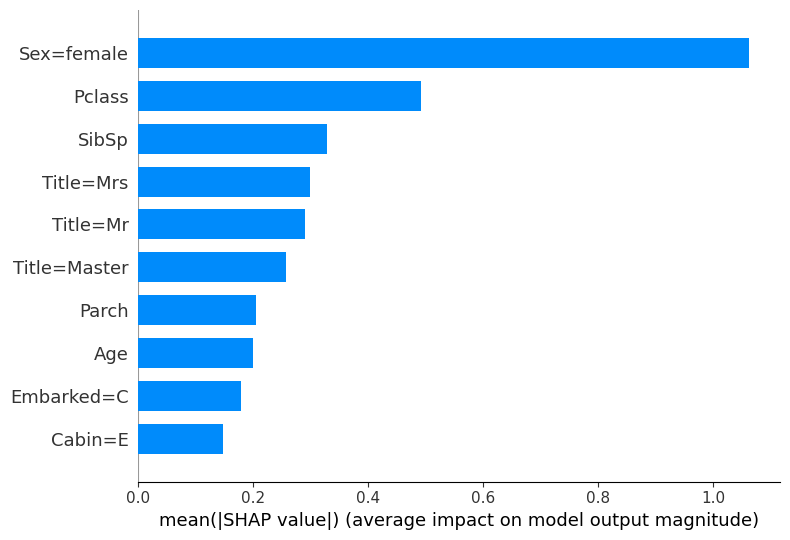

In [156]:
import shap
masker =  shap.maskers.Independent(data=X_test)
lr_auc_explainer = shap.LinearExplainer(lr_auc_model.best_estimator_.named_steps["clf"], masker=masker)
lr_auc_shap_values = lr_auc_explainer.shap_values(X_pipeline.toarray())
X_df = pd.DataFrame(X_pipeline.toarray(), columns=X_feature_names)
shap.summary_plot(lr_auc_shap_values, X_df, plot_type="bar", max_display=10);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


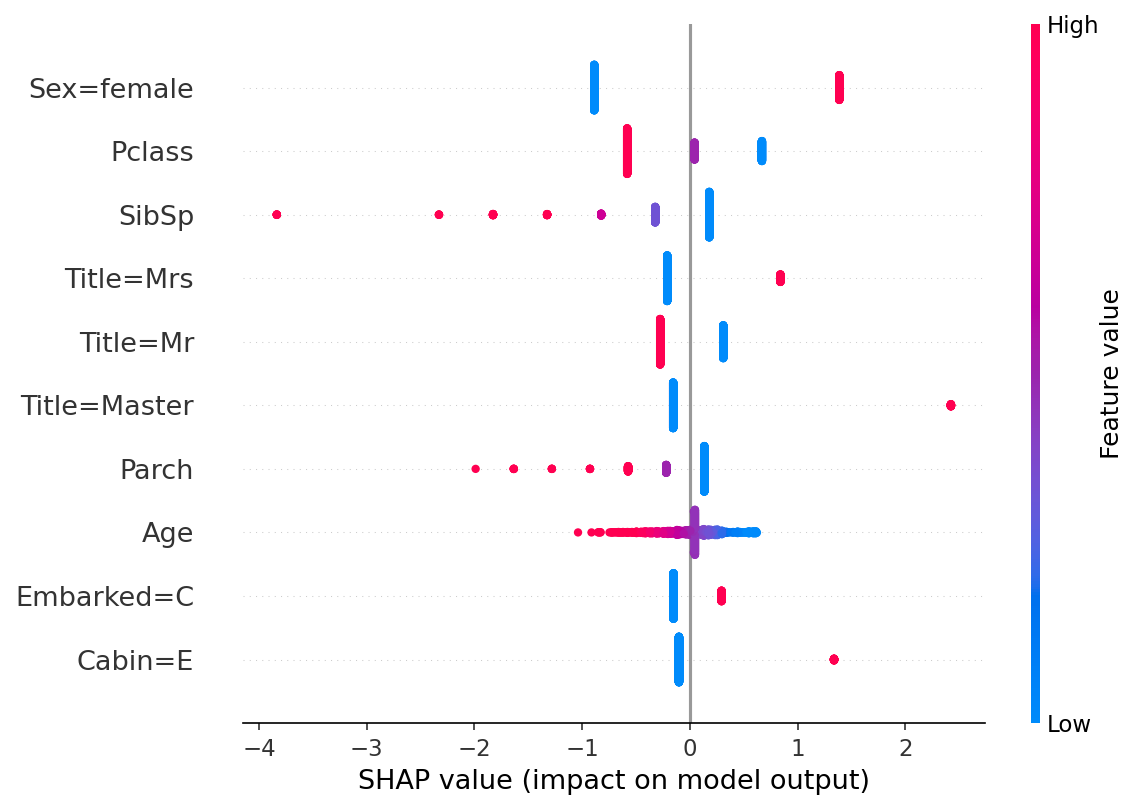

In [85]:
plt.figure(figsize=(10,6), dpi=150)
shap.summary_plot(lr_auc_shap_values, X_pipeline.toarray(), feature_names=X_feature_names, max_display=10)
plt.show();

# 4.Prediction Pipeline

In [86]:
## Prediction pipeline
import pickle
# Batch interference output csv file for operations
df_test = pd.read_csv('../data/raw/test.csv')

def prediction_model(dataframe):
  id_var = 'PassengerId'
  df_test_final = dataframe.drop([id_var], axis=1)
  X_df_test = final_data_processing_pipeline.transform(df_test_final)
  model = pickle.load(open('XGB_roc_auc_rs_cv_model.sav','rb'))
  predictions = model.predict(X_df_test)
  return predictions

# predictions = prediction_model(df_test,set_schema_cols=X_feature_names)
predictions = prediction_model(df_test)
test_predictions_df = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
# you could use any filename as your csv file output. We choose test_predictions here
test_predictions_df.to_csv('test_predictions_xgb.csv', index=False)

test_predictions_df_complete = pd.DataFrame({'Survived': predictions})
test_predictions_df_complete = pd.concat([df_test,test_predictions_df_complete], axis=1)
test_predictions_df_complete.to_csv('test_predictions_complete_xgb.csv', index=False)

# 5.Appendix - Analysis of other models

## 5.1. Decision Tree Classifer & Random Forest Classifier Analyses

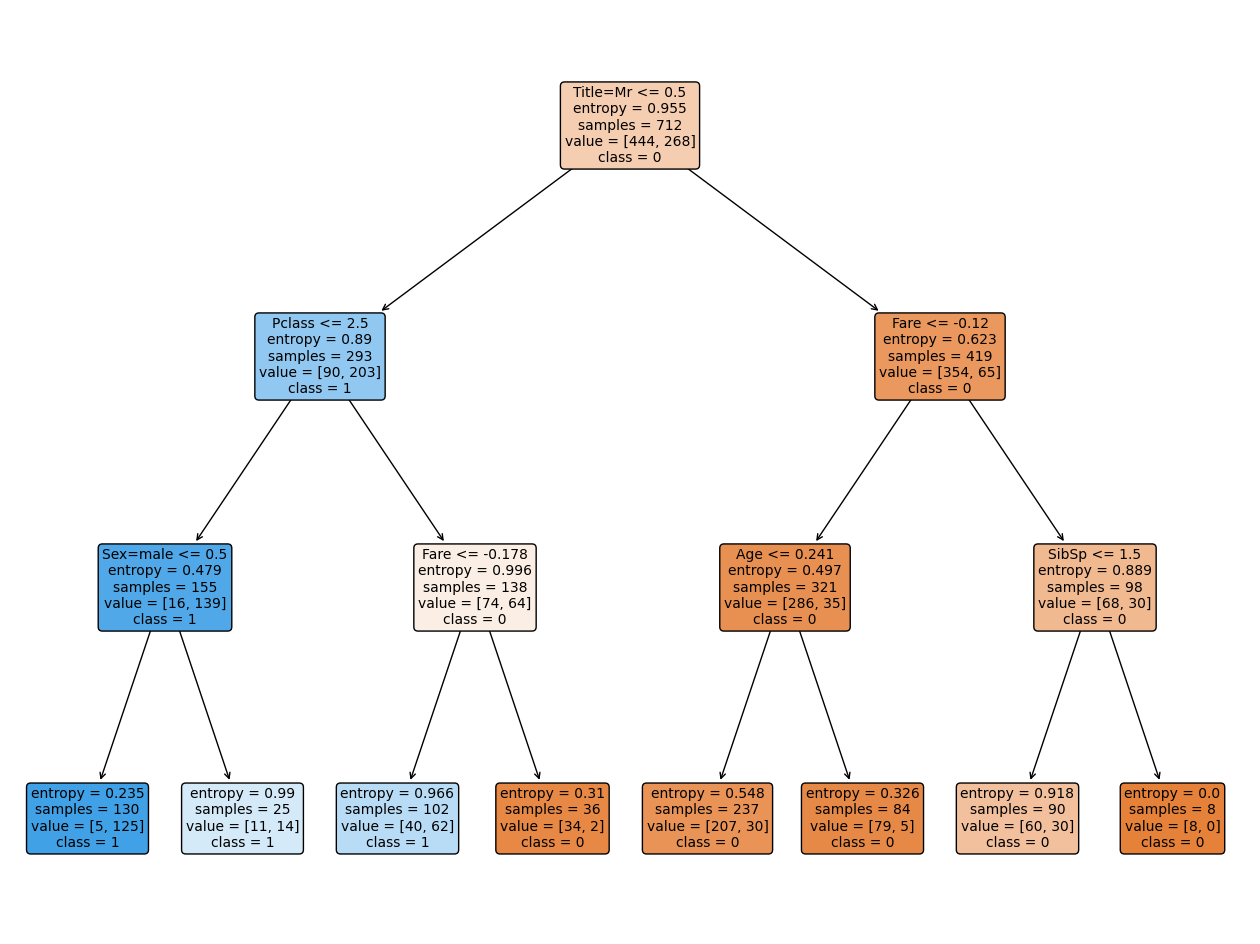

In [87]:
from sklearn.tree import plot_tree
dt_model = pickle.load(open('DT_roc_auc_rs_cv_model.sav','rb'))
plt.figure(figsize=(16,12))
plot_tree(dt_model.best_estimator_.steps[-1][1], filled=True, rounded=True, class_names=['0', '1'], fontsize=10, feature_names=X_feature_names)
plt.show()

In [88]:
from sklearn.tree import export_graphviz
export_graphviz(dt_model.best_estimator_.steps[-1][1], out_file=open("tree.dot","w"), feature_names = X_feature_names)

In [89]:
from sklearn.tree import export_text, export_graphviz

tree_rules = export_text(dt_model.best_estimator_.steps[-1][1], feature_names = X_feature_names)

print(tree_rules)

|--- Title=Mr <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Sex=male <= 0.50
|   |   |   |--- class: 1
|   |   |--- Sex=male >  0.50
|   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= -0.18
|   |   |   |--- class: 1
|   |   |--- Fare >  -0.18
|   |   |   |--- class: 0
|--- Title=Mr >  0.50
|   |--- Fare <= -0.12
|   |   |--- Age <= 0.24
|   |   |   |--- class: 0
|   |   |--- Age >  0.24
|   |   |   |--- class: 0
|   |--- Fare >  -0.12
|   |   |--- SibSp <= 1.50
|   |   |   |--- class: 0
|   |   |--- SibSp >  1.50
|   |   |   |--- class: 0



In [90]:
# |--- Title=Mr = 0           [Title = Not Mr]         
# |   |--- Pclass <= 2            [Pclass = 1,2]
# |   |   |--- Sex=female = 0         [male]-->['Survived']
# |   |   |   |--- class: 1   
# |   |   |--- Sex=female = 1         [female]-->['Survived']
# |   |   |   |--- class: 1
# |   |--- Pclass >  2.50         [Pclass = 3]
# |   |   |--- Fare <= -0.18          [Unscaled Fare <= 23.2594]-->['Survived']
# |   |   |   |--- class: 1
# |   |   |--- Fare >  -0.18          [Unscaled Fare > 23.2594]-->['Perished']
# |   |   |   |--- class: 0
# |--- Title=Mr = 1           [Title = Mr]   
# |   |--- Fare <= -0.12          [Fare <= 26.241]
# |   |   |--- Age <= 0.24            [Age <= 33.2]-->['Perished']
# |   |   |   |--- class: 0
# |   |   |--- Age >  0.24            [Age => 33.2]-->['Perished']
# |   |   |   |--- class: 0
# |   |--- Fare >  -0.12          [Fare => 26.241]
# |   |   |--- SibSp <= 1.50           [SibSp <= 1]-->['Perished']
# |   |   |   |--- class: 0
# |   |   |--- SibSp >  1.50           [SibSp > 1]-->['Perished']
# |   |   |   |--- class: 0

In [91]:
z = - 0.18
df['Fare'].mean() + z*df['Fare'].std()

23.259390821082075

In [92]:
z = - 0.12
df['Fare'].mean() + z*df['Fare'].std()

26.240996536912927

In [93]:
z = 0.24
df['Age'].mean() + z*df['Age'].std()

33.18547700681899

How to implement Decision Trees from scratch with Python by AssemblyAI

https://www.youtube.com/watch?v=NxEHSAfFlK8

https://github.com/AssemblyAI-Examples/Machine-Learning-From-Scratch


In [94]:
print(dir(dt_model),)

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_feature_names', '_check_n_features', '_check_refit_for_multimetric', '_estimator_type', '_format_results', '_get_param_names', '_get_tags', '_more_tags', '_pairwise', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_run_search', '_select_best_index', '_validate_data', 'best_estimator_', 'best_index_', 'best_params_', 'best_score_', 'classes_', 'cv', 'cv_results_', 'decision_function', 'error_score', 'estimator', 'fit', 'get_params', 'inverse_transform', 'multimetric_', 'n_features_in_', 'n_iter', 'n_jobs', 'n_splits_', 'param_distributions'

In [95]:
type(dt_model)

sklearn.model_selection._search.RandomizedSearchCV

In [96]:
print(dir(dt_model.best_estimator_),)

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_can_inverse_transform', '_can_transform', '_check_feature_names', '_check_fit_params', '_check_n_features', '_estimator_type', '_final_estimator', '_fit', '_get_param_names', '_get_params', '_get_tags', '_iter', '_log_message', '_more_tags', '_pairwise', '_replace_estimator', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_params', '_sk_visual_block_', '_validate_data', '_validate_names', '_validate_steps', 'classes_', 'decision_function', 'feature_names_in_', 'fit', 'fit_

In [97]:
dt_model.best_estimator_.steps[-1][1]

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)

### Definition of Entropy (Information Gain) & Gini impurity

$H(\{p_{c}\}) = - \sum_{c=0}^{n-1} p_{c} \log_{2} p_{c}$, 

where $c= 0, \ldots , n-1$,

represents the labels of the $n$ classes, and $p_{c}$ is the proportion of class $c$

note that $\sum_{c} p_{c} = 1$.


\
When $n=2$, set $p:= p_{0}$ for ease of analysis

$ H(p) = - [p \log_{2} p + (1-p) \log_{2} (1-p)] $.

When 

$ p \rightarrow 0$, $p \log_{2} p \rightarrow 0$,

and  

$(1-p) \log_{2} (1-p) \rightarrow 0$ , and thus $H \rightarrow 0$.

By symmetry, $p \rightarrow 1$, $H \rightarrow 0$.


By a removable discontinuity argument and that H is continuous on (0,1), we can define $H(p)=0$ when $p=0,1$ (achieves global minima).

When $p = \frac{1}{2}$, $H = 1$, achieves global maxima.

By calculus, we can verify that $0 \leq H \leq 1$, and the shape of the function $H$ resembles a 'inverted' U-shape on [0,1], i.e. concave on [0,1].

See more at https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/

Note that Gini impurity is defined as 

$$ G(\{p\}_{c}) = 1- \sum_{c=0}^{n-1} p_{c}^{2}, $$
where $p_{c} \in [0,1]$, and $\sum_{c} p_{c} =1$ 

and has similar properties as entropy
except that $0 \leq G \leq 0.5$, with $G(0.5)=0.5$.


https://datascience.stackexchange.com/questions/10228/when-should-i-use-gini-impurity-as-opposed-to-information-gain-entropy

Gini Impurity $G$ is a first order approximation to Information Gain $IG$
To see that first note that the sum of all probabilities $p_i$ over $N$ classes is $\sum_{i=1}^N p_i=1$. So we can rewrite Gini Impurity like
$$ G = 1 - \sum_{i=1}^N p_i^2 = \sum_{i=1}^N p_i - \sum_{i=1}^N p_i^2 = \sum_{i=1}^N p_i(1-p_i)$$

To rewrite Information Gain note that the natural logarithm can be expressed as an infinite series
$$\ln(1-x) = -x - \frac{1}{2}x^2 - \frac{1}{3}x^3 - \ldots$$

The Information Gain can then be expressed like

$
\begin{align}
IG &= - \sum_{i=1}^N p_i \ln(p_i) = - \sum_{i=1}^N p_i \ln(1 - (1-p_i)) \\
&= - \sum_{i=1}^N p_i \left[-(1-p_i) - \frac{1}{2}(1-p)^2 - \frac{1}{3}(1-p)^3 + \ldots      \right] \\
&= \sum_{i=1}^N \color{red}{p_i } \left[\color{red}{(1-p_i)} + \frac{1}{2}(1-p)^2 + \frac{1}{3}(1-p)^3 + \ldots      \right]
\end{align}
$

The first term (in red) in this infinite series to compute the Information Gain is exactly the Gini Impurity $G$.

So which metric to use? If you need maximum speed use the Gini Impurity. If you need the theoretical exact solution use Information Gain. And as a compromise you can for example use the second order approximation to Information Gain:

$IG \approx \sum_{i=1}^N p_i (1-p_i) + p_i\frac{1}{2}(1-p)^2 = \frac{1}{2}\sum_{i=1}^N p_i(1-p_i)(3-p_i)$

The plot below (screenshot from Wolfram Alpha with x=pi) shows Gini Impurity in red, Information Gain in blue and the second order approximation in green. The second order approximation to Information Gain sits basically in the middle between the Gini Impurity and Information Gain.

For practical usage, we can refer to this article

https://ekamperi.github.io/machine%20learning/2021/04/13/gini-index-vs-entropy-decision-trees.html

Notice how for small values of p, Gini is consistently lower than entropy. Therefore, it penalizes less small impurities. This is a crucial observation that will prove helpful in the context of imbalanced datasets.

So when do we use Gini impurity versus information gain via entropy reduction? Both metrics work more or less the same, and in only a few cases do the results differ considerably. Having said that, `there’s a scenario where entropy might be more prudent: imbalanced datasets`.

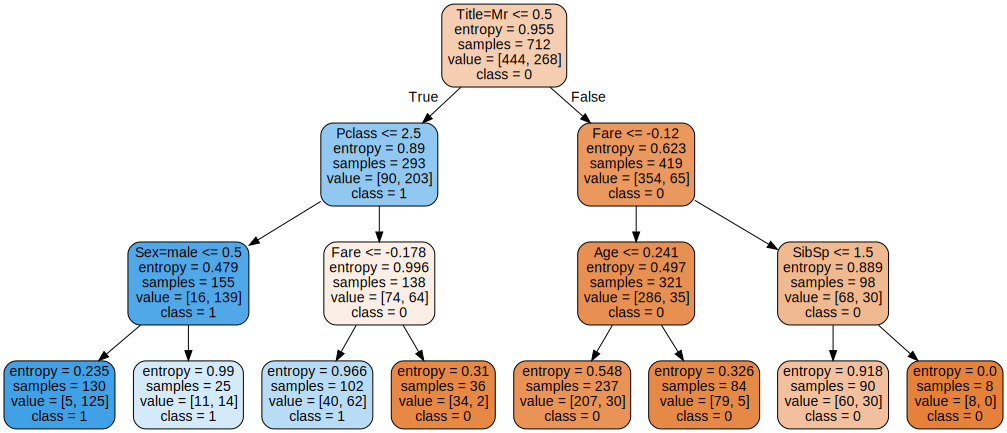

In [98]:
from sklearn.tree import export_graphviz
import graphviz
# Export the decision tree as a Graphviz representation
dot_data = export_graphviz(dt_model.best_estimator_.steps[-1][1], filled=True, rounded=True, class_names=['0', '1'], feature_names=X_feature_names)

# Create a Graphviz object and display the decision tree
graph = graphviz.Source(dot_data)
graph

In [99]:
# Save the Graphviz visualization as a PDF file
graph.render('decision_tree.pdf')

# Save the Graphviz visualization as a PNG file
graph.render('decision_tree.png')

# Save the Graphviz visualization as a JPG file
graph.render('decision_tree.jpg')

'decision_tree.jpg.pdf'

In [100]:
# Get the feature importances
importances = dt_model.best_estimator_.steps[-1][1].feature_importances_

# Print the feature importances
print(importances)

[0.00840835 0.15250342 0.17787907 0.06881134 0.01612387 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.57627395
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


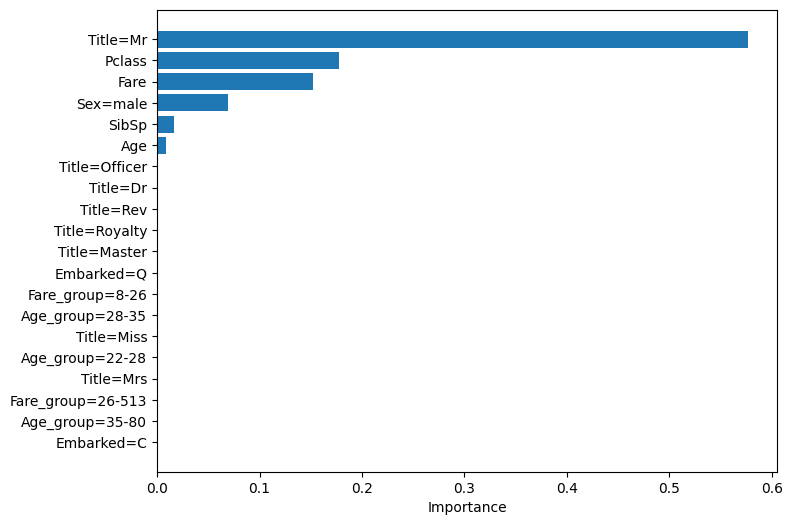

In [101]:
import matplotlib.pyplot as plt

# Get the feature importances
importances = dt_model.best_estimator_.steps[-1][1].feature_importances_

# Get the feature names
feature_names = X_feature_names

# Sort the feature importances in descending order
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=False)

# Get the top-ranked features
top_features = sorted_importances[-20:]

# Extract the feature names and importances
feature_names, importances = zip(*top_features)

# Set the figure size
plt.figure(figsize=(8, 6))

# Draw a horizontal bar chart
plt.barh(feature_names, importances)

# Set the x-axis label
plt.xlabel('Importance')

# Show the plot
plt.show()

## 5.2. Random Forest

How to visualize multiple trees from Bagged Trees or Random Forests

https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/CART/Visualization/DecisionTreesVisualization.ipynb

How to implement Random Forest from scratch with Python

https://www.youtube.com/watch?v=kFwe2ZZU7yw

https://github.com/AssemblyAI-Examples/Machine-Learning-From-Scratch


## 5.2. KNN Classifier Analysis

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


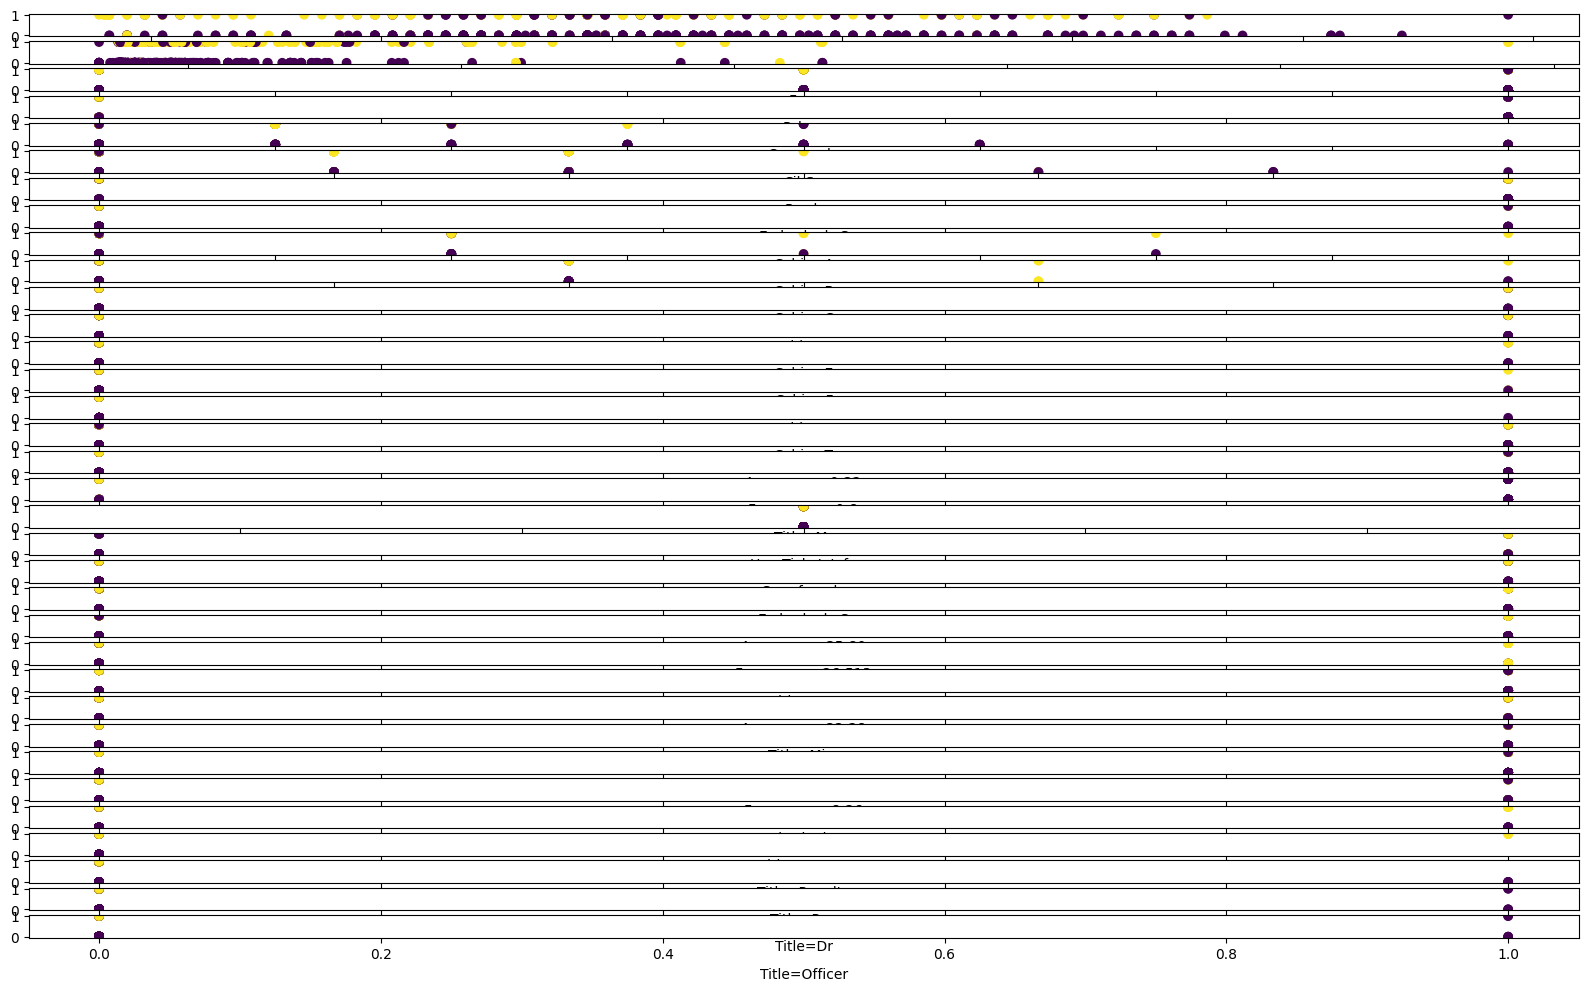

In [102]:
knn_model = pickle.load(open('KNN_roc_auc_rs_cv_model.sav','rb'))
# Get the feature names
feature_names = X_feature_names

# Get the number of features
num_features = X_train.toarray().shape[1]

# Set the figure size
plt.figure(figsize=(20, 12))

# Loop over the features
for i in range(num_features):
    # Get the feature values
    x = X_train.toarray()[:, i]
    
    # Create a subplot
    plt.subplot(num_features, 1, i+1)
    
    # Scatterplot the feature values and color by the predicted class
    plt.scatter(x, y_train, c= knn_model.predict(X_train), cmap='viridis')
    
    # Set the x-axis label
    plt.xlabel(feature_names[i])

# Show the plot
plt.show()

In [103]:
# Create the KNN model
model = KNeighborsClassifier()

# Define the range of values for k
k_range = list(range(1, 31))

# Create a parameter grid for k
param_grid = {'n_neighbors': k_range}

# Create a grid search with 5-fold cross-validation
grid = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search
grid.fit(X_train, y_train)

# Get the best value of k
best_k = grid.best_params_['n_neighbors']

# Print the best value of k
print(f'Best value of k: {best_k}')

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

Best value of k: 7


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

## 5.3. SHAP Analysis (details)

In [104]:
import shap
import xgboost as xgb

# Shap xgboost pipeline # initial pipeline for all dataprocessing [ENSURE THAT WE USE get_dummies! so that all values
# in X are numerialized] to get X, traintest split
xgb_simple_model=xgb.XGBClassifier(max_depth=3,tree_method="gpu_hist",enable_categorical=True)
xgb_simple_model.fit(X_pipeline, y)
explainer = shap.TreeExplainer(xgb_simple_model)

In [105]:
X_feature_names=list(final_data_processing_pipeline[-1].get_feature_names_out())
print(X_feature_names,)

['Age', 'Fare', 'Pclass', 'Sex=male', 'SibSp', 'Parch', 'Embarked=S', 'Cabin=A', 'Cabin=B', 'Cabin=C', 'Cabin=D', 'Cabin=E', 'Cabin=F', 'Cabin=G', 'Cabin=T', 'Age_group=0-22', 'Fare_group=0-8', 'Title=Mr', 'Has_Ticket_Info', 'Sex=female', 'Embarked=C', 'Age_group=35-80', 'Fare_group=26-513', 'Title=Mrs', 'Age_group=22-28', 'Title=Miss', 'Age_group=28-35', 'Fare_group=8-26', 'Embarked=Q', 'Title=Master', 'Title=Royalty', 'Title=Rev', 'Title=Dr', 'Title=Officer']


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


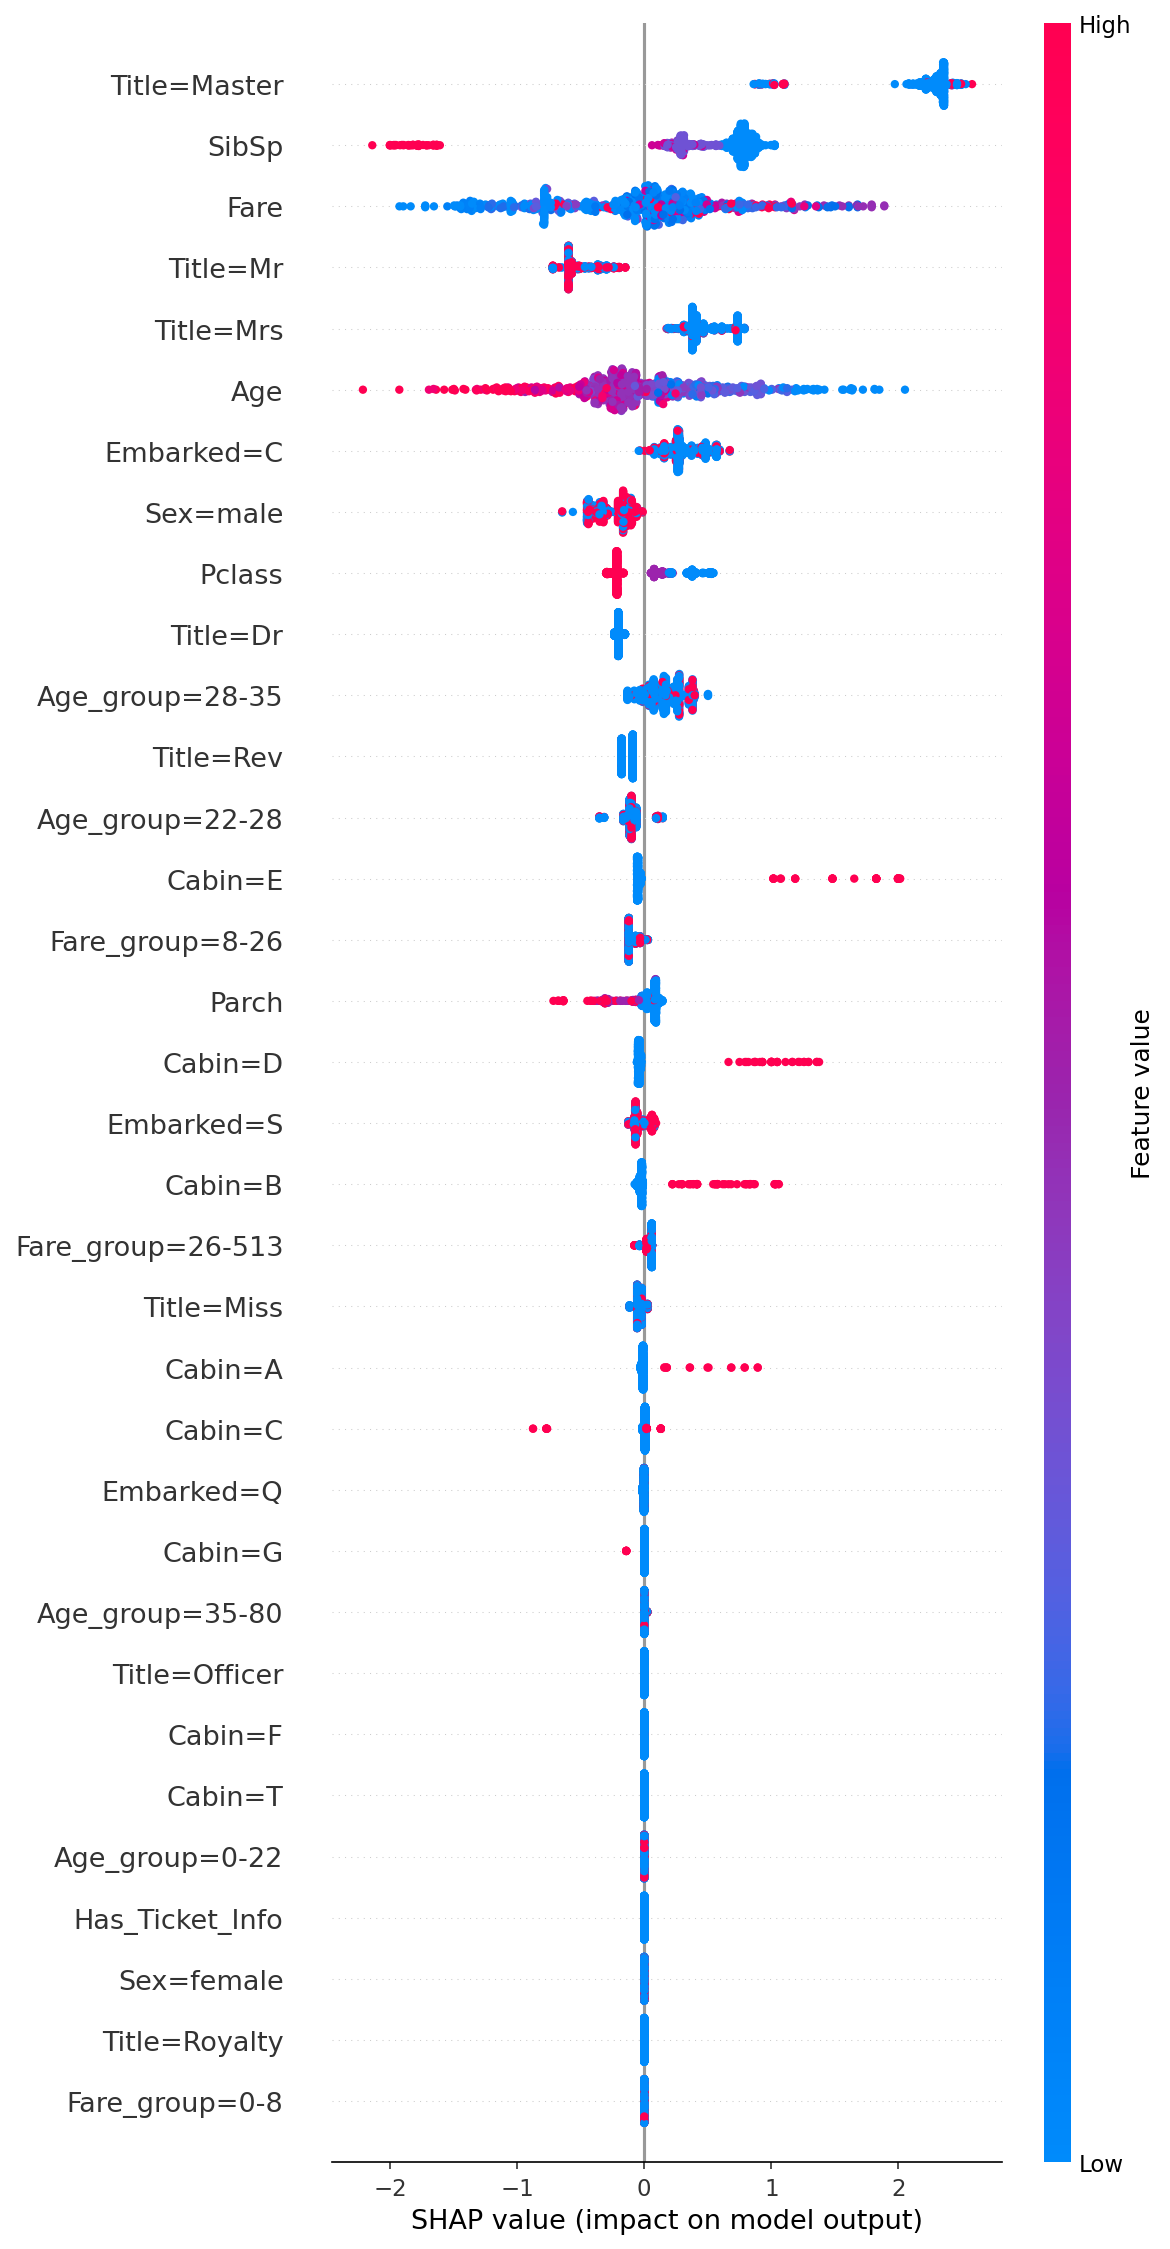

In [106]:
shap_values = explainer.shap_values(X_pipeline.toarray())

plt.figure(figsize=(10,6), dpi=150)

shap.summary_plot(shap_values, X_pipeline.toarray(), feature_names=X_feature_names, max_display=40)
plt.show();

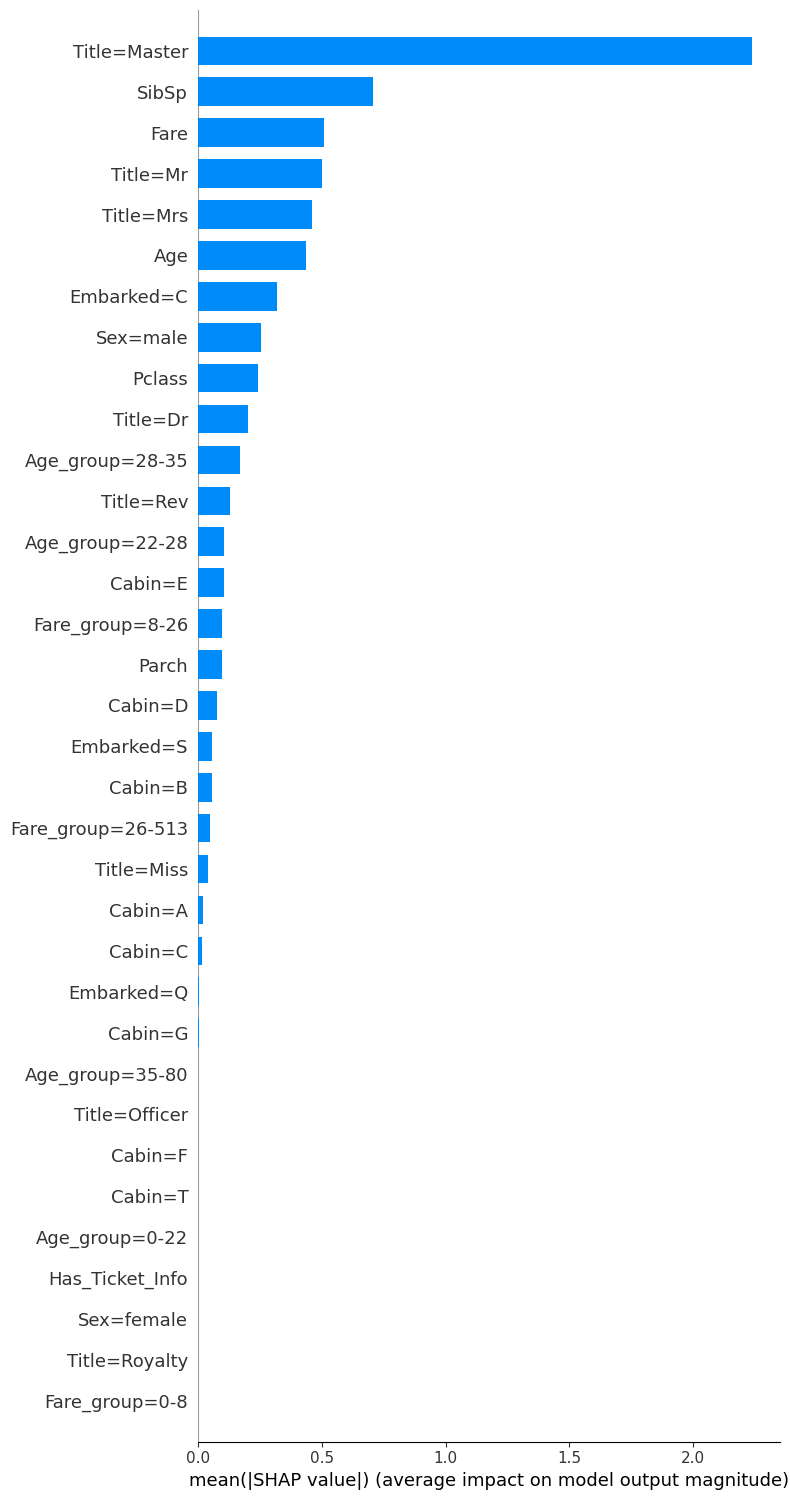

In [107]:
X_df = pd.DataFrame(X_pipeline.toarray(), columns=X_feature_names)
shap.summary_plot(shap_values, X_df, plot_type="bar", max_display=40)

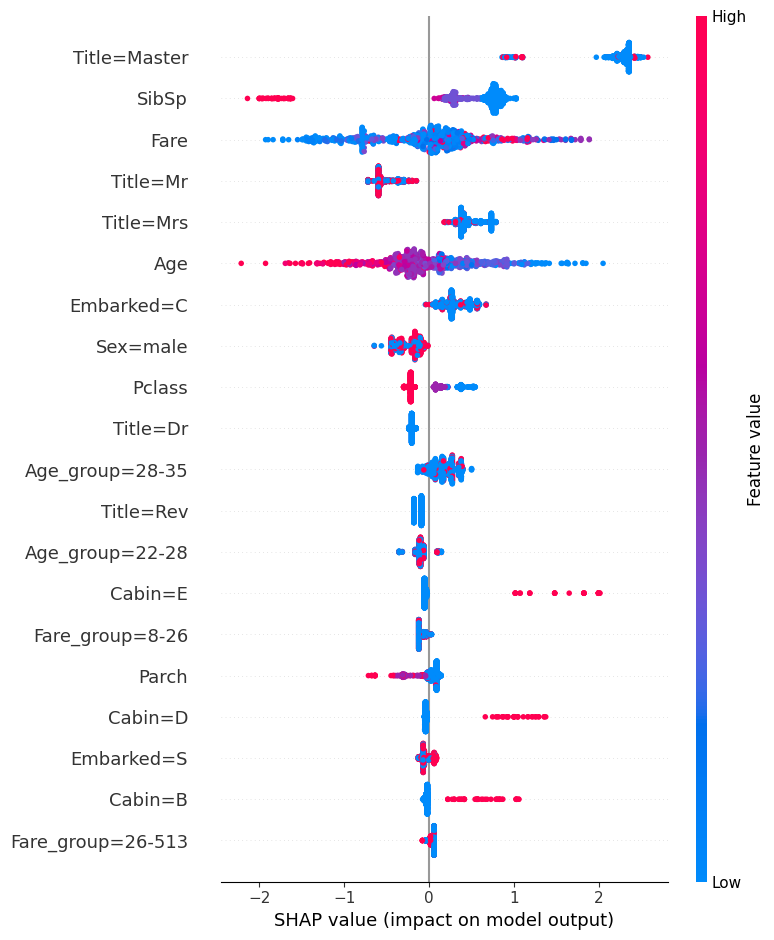

In [108]:
shap.summary_plot(shap_values, X_df)

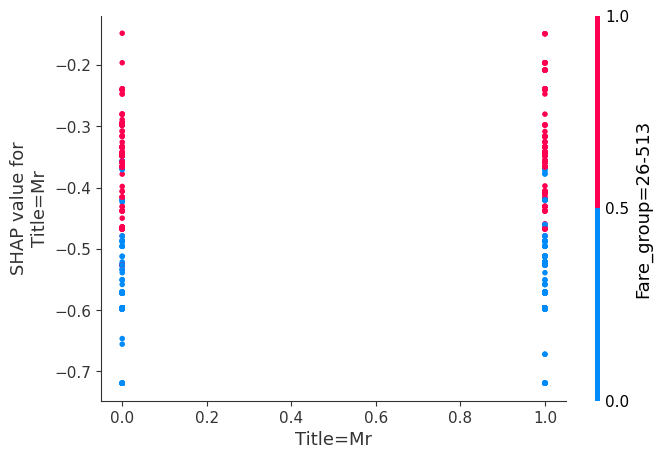

In [109]:
shap.dependence_plot("Title=Mr", shap_values, X_df)

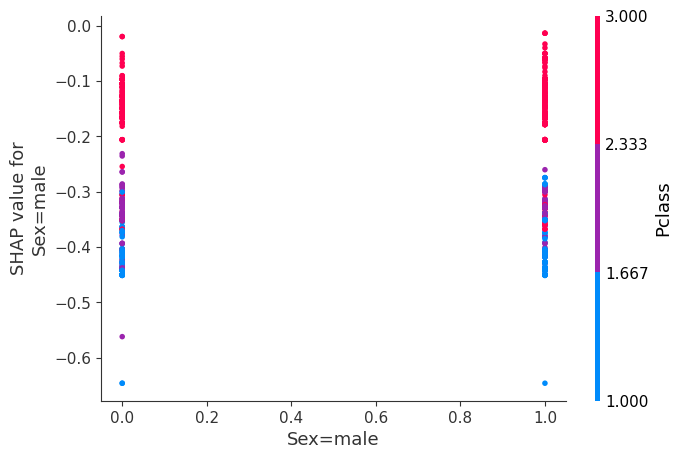

In [110]:
shap.dependence_plot("Sex=male", shap_values, X_df)

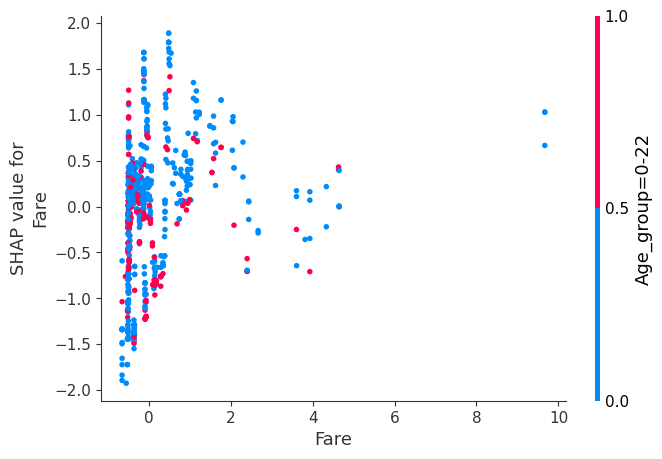

In [111]:
shap.dependence_plot(ind="Fare", shap_values=shap_values, features=X_df,  interaction_index="Age_group=0-22")